In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

297


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.75,fy=0.75, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:42<00:00,  1.71s/it]


In [12]:
Dataset = 'Small Village Dataset'

In [13]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 83.4751181602478 [s] ... size 3251.738624 MB


In [ ]:
'''f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [14]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [15]:
from timeit import default_timer as timer

In [16]:
time_all = []

In [17]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [18]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:33<00:00,  1.80it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 378149.12it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 160342.94it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [06:16<00:00,  6.27s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 315756.89it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 145341.17it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
''''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:09<00:00,  6.28it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 95596.67it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [19]:
start = timer()

Threshl=80;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:56<00:00,  1.06it/s]


In [20]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 44783.03it/s]


In [ ]:
'''all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [21]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 80)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:38<00:00,  1.65s/it]


In [22]:
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 95560.37it/s]


In [ ]:
'''all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_left

In [ ]:
''''import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_right

FAST + SIFT

In [23]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=70)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:17<00:00,  2.29s/it]


In [24]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 79038.39it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [25]:

print(len(left_files_path))

61


In [26]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [43]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [06:09<00:00,  6.16s/it]


In [44]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 165347.07it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [45]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 3, hessianThreshold = 60 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [07:49<00:00,  7.83s/it]


In [46]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 389865.59it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:08<00:00,  2.14s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 49388.33it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [27]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [28]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [29]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [30]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005538225173950195 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005404472351074219 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [47]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:11,  5.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 99
Number of Robust matches 34



Number of matches 1000
Number of matches After Lowe's Ratio 113
Number of Robust matches 38




  7%|▋         | 4/61 [00:00<00:08,  6.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 106
Number of Robust matches 30



Number of matches 1000
Number of matches After Lowe's Ratio 126
Number of Robust matches 53




  8%|▊         | 5/61 [00:00<00:08,  6.78it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 82
Number of Robust matches 38



Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 49




 11%|█▏        | 7/61 [00:00<00:07,  7.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 149
Number of Robust matches 104




 13%|█▎        | 8/61 [00:01<00:12,  4.41it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 114
Number of Robust matches 53




 16%|█▋        | 10/61 [00:01<00:12,  4.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 45




 20%|█▉        | 12/61 [00:02<00:08,  5.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 141
Number of Robust matches 43




 23%|██▎       | 14/61 [00:02<00:07,  5.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 33
Number of Robust matches 23


Number of matches After Lowe's Ratio New 71
Number of Robust matches New 24



Number of matches 1000
Number of matches After Lowe's Ratio 9
Number of Robust matches 6


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 7




 26%|██▌       | 16/61 [00:02<00:06,  6.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 16
Number of Robust matches 11


Number of matches After Lowe's Ratio New 60
Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 105
Number of Robust matches 45




 30%|██▉       | 18/61 [00:02<00:05,  7.38it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 31



Number of matches 1001
Number of matches After Lowe's Ratio 82
Number of Robust matches 28




 31%|███       | 19/61 [00:03<00:06,  6.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 76
Number of Robust matches 22


Number of matches After Lowe's Ratio New 165
Number of Robust matches New 22



Number of matches 1000
Number of matches After Lowe's Ratio 84


 34%|███▍      | 21/61 [00:03<00:05,  7.48it/s]

Number of Robust matches 32



Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 46




 38%|███▊      | 23/61 [00:03<00:04,  7.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 143
Number of Robust matches 99



Number of matches 1001
Number of matches After Lowe's Ratio 121
Number of Robust matches 85




 41%|████      | 25/61 [00:03<00:05,  7.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 83
Number of Robust matches 32



Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 24


Number of matches After Lowe's Ratio New 148
Number of Robust matches New 33




 43%|████▎     | 26/61 [00:04<00:05,  6.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 43
Number of Robust matches 10


Number of matches After Lowe's Ratio New 118
Number of Robust matches New 10




 44%|████▍     | 27/61 [00:04<00:06,  5.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 24


Number of matches After Lowe's Ratio New 191
Number of Robust matches New 37




 46%|████▌     | 28/61 [00:04<00:05,  5.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 31
Number of Robust matches 11


Number of matches After Lowe's Ratio New 81
Number of Robust matches New 14



Number of matches 1000
Number of matches After Lowe's Ratio 15
Number of Robust matches 5


Number of matches After Lowe's Ratio New 83


 49%|████▉     | 30/61 [00:04<00:05,  5.57it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 17
Number of Robust matches 8


Number of matches After Lowe's Ratio New 67
Number of Robust matches New 11




 51%|█████     | 31/61 [00:05<00:05,  5.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 53
Number of Robust matches 17


Number of matches After Lowe's Ratio New 122
Number of Robust matches New 22



Number of matches 1000
Number of matches After Lowe's Ratio 132


 54%|█████▍    | 33/61 [00:05<00:04,  6.41it/s]

Number of Robust matches 33



Number of matches 1000
Number of matches After Lowe's Ratio 101
Number of Robust matches 28




 57%|█████▋    | 35/61 [00:05<00:03,  7.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 82
Number of Robust matches 29



Number of matches 1000
Number of matches After Lowe's Ratio 94
Number of Robust matches 42




 61%|██████    | 37/61 [00:05<00:03,  7.74it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 95
Number of Robust matches 58




 64%|██████▍   | 39/61 [00:06<00:02,  8.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 120
Number of Robust matches 63



Number of matches 1000
Number of matches After Lowe's Ratio 141
Number of Robust matches 92




 66%|██████▌   | 40/61 [00:06<00:02,  7.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 17


Number of matches After Lowe's Ratio New 113
Number of Robust matches New 19



Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 22


Number of matches After Lowe's Ratio New 172


 69%|██████▉   | 42/61 [00:06<00:03,  6.03it/s]

Number of Robust matches New 31



Number of matches 1001
Number of matches After Lowe's Ratio 77
Number of Robust matches 20


Number of matches After Lowe's Ratio New 154
Number of Robust matches New 23




 70%|███████   | 43/61 [00:06<00:03,  5.89it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 50
Number of Robust matches 16


Number of matches After Lowe's Ratio New 109
Number of Robust matches New 25



Number of matches 1000
Number of matches After Lowe's Ratio 19
Number of Robust matches 8


Number of matches After Lowe's Ratio New 48


 74%|███████▍  | 45/61 [00:07<00:02,  5.97it/s]

Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 3
Number of Robust matches 0


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 5




 75%|███████▌  | 46/61 [00:07<00:02,  5.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 57
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 20
Number of Robust matches 14


Number of matches After Lowe's Ratio New 70
Number of Robust matches New 22

 79%|███████▊  | 48/61 [00:07<00:01,  6.98it/s]





Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 27




 80%|████████  | 49/61 [00:07<00:02,  5.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 12


Number of matches After Lowe's Ratio New 154
Number of Robust matches New 15




 84%|████████▎ | 51/61 [00:08<00:01,  6.93it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 72
Number of Robust matches 30



Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 34




 87%|████████▋ | 53/61 [00:08<00:01,  7.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 42



Number of matches 1000
Number of matches After Lowe's Ratio 76
Number of Robust matches 51




 90%|█████████ | 55/61 [00:08<00:00,  8.32it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 83
Number of Robust matches 68



Number of matches 1000
Number of matches After Lowe's Ratio 68
Number of Robust matches 60




 93%|█████████▎| 57/61 [00:08<00:00,  8.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 80
Number of Robust matches 69



Number of matches 1001
Number of matches After Lowe's Ratio 61
Number of Robust matches 32




 95%|█████████▌| 58/61 [00:08<00:00,  6.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 23


Number of matches After Lowe's Ratio New 158
Number of Robust matches New 30




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 18


Number of matches After Lowe's Ratio New 101
Number of Robust matches New 33



Number of matches 1000
Number of matches After Lowe's Ratio 12
Number of Robust matches 8


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 17




  3%|▎         | 2/60 [00:00<00:07,  7.83it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 73
Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 49
Number of Robust matches 18


Number of matches After Lowe's Ratio New 115
Number of Robust matches New 26




  5%|▌         | 3/60 [00:00<00:07,  7.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 20


Number of matches After Lowe's Ratio New 123
Number of Robust matches New 29



Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 22


Number of matches After Lowe's Ratio New 150


  8%|▊         | 5/60 [00:00<00:07,  7.06it/s]

Number of Robust matches New 23



Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 51




 12%|█▏        | 7/60 [00:00<00:06,  7.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 101
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 51




 15%|█▌        | 9/60 [00:01<00:06,  8.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 66



Number of matches 1000
Number of matches After Lowe's Ratio 128
Number of Robust matches 76




 18%|█▊        | 11/60 [00:01<00:05,  8.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 56



Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 72




 22%|██▏       | 13/60 [00:01<00:05,  8.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 68
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 128
Number of Robust matches 67




 25%|██▌       | 15/60 [00:01<00:05,  8.53it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 120
Number of Robust matches 39



Number of matches 1000
Number of matches After Lowe's Ratio 83
Number of Robust matches 28




 27%|██▋       | 16/60 [00:02<00:05,  8.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 97
Number of Robust matches 30



Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 22


Number of matches After Lowe's Ratio New 131


 30%|███       | 18/60 [00:02<00:05,  7.65it/s]

Number of Robust matches New 31



Number of matches 1000
Number of matches After Lowe's Ratio 80
Number of Robust matches 47




 33%|███▎      | 20/60 [00:02<00:05,  7.80it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 29
Number of Robust matches 13


Number of matches After Lowe's Ratio New 86
Number of Robust matches New 24



Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 31




 37%|███▋      | 22/60 [00:02<00:04,  8.03it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 116
Number of Robust matches 43



Number of matches 1000
Number of matches After Lowe's Ratio 125
Number of Robust matches 56




 40%|████      | 24/60 [00:03<00:04,  8.34it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 135
Number of Robust matches 45



Number of matches 1000
Number of matches After Lowe's Ratio 126
Number of Robust matches 64




 43%|████▎     | 26/60 [00:03<00:03,  8.63it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 98
Number of Robust matches 59



Number of matches 1000
Number of matches After Lowe's Ratio 93
Number of Robust matches 66




 47%|████▋     | 28/60 [00:03<00:03,  8.28it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 107
Number of Robust matches 80



Number of matches 1000
Number of matches After Lowe's Ratio 36
Number of Robust matches 21


Number of matches After Lowe's Ratio New 109
Number of Robust matches New 28




 50%|█████     | 30/60 [00:03<00:03,  8.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 52



Number of matches 1000
Number of matches After Lowe's Ratio 140
Number of Robust matches 53




 53%|█████▎    | 32/60 [00:03<00:03,  8.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 129
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 100
Number of Robust matches 35




 57%|█████▋    | 34/60 [00:04<00:03,  8.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 55



Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 28




 60%|██████    | 36/60 [00:04<00:02,  8.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 43
Number of Robust matches 21


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 28



Number of matches 1000
Number of matches After Lowe's Ratio 95
Number of Robust matches 37




 63%|██████▎   | 38/60 [00:04<00:02,  8.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 108
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 136
Number of Robust matches 44




 67%|██████▋   | 40/60 [00:04<00:02,  8.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 144
Number of Robust matches 52



Number of matches 1001
Number of matches After Lowe's Ratio 124
Number of Robust matches 76




 70%|███████   | 42/60 [00:05<00:02,  7.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 46
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 22
Number of Robust matches 13


Number of matches After Lowe's Ratio New 84
Number of Robust matches New 11




 73%|███████▎  | 44/60 [00:05<00:02,  7.80it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 36
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 28
Number of Robust matches 19


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 26




 77%|███████▋  | 46/60 [00:05<00:01,  8.21it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 91
Number of Robust matches 53



Number of matches 1000
Number of matches After Lowe's Ratio 112
Number of Robust matches 46




 80%|████████  | 48/60 [00:05<00:01,  8.27it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 83
Number of Robust matches 31



Number of matches 1001
Number of matches After Lowe's Ratio 90
Number of Robust matches 30




 83%|████████▎ | 50/60 [00:06<00:01,  7.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 22


Number of matches After Lowe's Ratio New 101
Number of Robust matches New 34



Number of matches 1000
Number of matches After Lowe's Ratio 75
Number of Robust matches 28




 87%|████████▋ | 52/60 [00:06<00:01,  6.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 41
Number of Robust matches 17


Number of matches After Lowe's Ratio New 116
Number of Robust matches New 22




 90%|█████████ | 54/60 [00:06<00:00,  6.85it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 69
Number of Robust matches 23


Number of matches After Lowe's Ratio New 153
Number of Robust matches New 26



Number of matches 1000
Number of matches After Lowe's Ratio 119
Number of Robust matches 42




 93%|█████████▎| 56/60 [00:07<00:00,  7.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 123
Number of Robust matches 46



Number of matches 1001
Number of matches After Lowe's Ratio 122
Number of Robust matches 62




 98%|█████████▊| 59/60 [00:07<00:00,  8.00it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 94
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 94
Number of Robust matches 79



Number of matches 1000
Number of matches After Lowe's Ratio 127
Number of Robust matches 96




In [48]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.08307194709777832 [s] ... size 0.006368 MB


In [49]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006682395935058594 [s] ... size 0.006296 MB


In [50]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [31]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/61 [00:04<04:32,  4.54s/it]


Number of matches 22104
Number of matches After Lowe's Ratio 6053
Number of Robust matches 1753




  3%|▎         | 2/61 [00:08<04:21,  4.44s/it]


Number of matches 23058
Number of matches After Lowe's Ratio 8286
Number of Robust matches 2469




  5%|▍         | 3/61 [00:12<04:11,  4.34s/it]


Number of matches 18335
Number of matches After Lowe's Ratio 5909
Number of Robust matches 1897




  7%|▋         | 4/61 [00:16<03:50,  4.04s/it]


Number of matches 18403
Number of matches After Lowe's Ratio 5249
Number of Robust matches 2130




  8%|▊         | 5/61 [00:19<03:35,  3.85s/it]


Number of matches 21119
Number of matches After Lowe's Ratio 3029
Number of Robust matches 1039




 10%|▉         | 6/61 [00:25<03:58,  4.34s/it]


Number of matches 35225
Number of matches After Lowe's Ratio 1857
Number of Robust matches 21


Number of matches After Lowe's Ratio New 354
Number of Robust matches New 9




 11%|█▏        | 7/61 [00:32<04:45,  5.28s/it]


Number of matches 30096
Number of matches After Lowe's Ratio 13532
Number of Robust matches 9754




 13%|█▎        | 8/61 [00:38<04:44,  5.37s/it]


Number of matches 19313
Number of matches After Lowe's Ratio 7259
Number of Robust matches 3940




 15%|█▍        | 9/61 [00:41<04:08,  4.78s/it]


Number of matches 18455
Number of matches After Lowe's Ratio 6042
Number of Robust matches 2680




 16%|█▋        | 10/61 [00:45<03:45,  4.42s/it]


Number of matches 19110
Number of matches After Lowe's Ratio 6375
Number of Robust matches 2087




 18%|█▊        | 11/61 [00:48<03:28,  4.16s/it]


Number of matches 21369
Number of matches After Lowe's Ratio 5192
Number of Robust matches 1292




 20%|█▉        | 12/61 [00:52<03:23,  4.16s/it]


Number of matches 21545
Number of matches After Lowe's Ratio 5256
Number of Robust matches 1262




 21%|██▏       | 13/61 [00:59<03:59,  4.99s/it]


Number of matches 53544
Number of matches After Lowe's Ratio 4468
Number of Robust matches 466



Number of matches 93036
Number of matches After Lowe's Ratio 2110
Number of Robust matches 9


Number of matches After Lowe's Ratio New 221


 23%|██▎       | 14/61 [01:16<06:43,  8.60s/it]

Number of Robust matches New 8




 25%|██▍       | 15/61 [01:34<08:46, 11.45s/it]


Number of matches 40715
Number of matches After Lowe's Ratio 7096
Number of Robust matches 3650




 26%|██▌       | 16/61 [01:43<07:51, 10.47s/it]


Number of matches 25937
Number of matches After Lowe's Ratio 4177
Number of Robust matches 1486




 28%|██▊       | 17/61 [01:48<06:28,  8.82s/it]


Number of matches 22049
Number of matches After Lowe's Ratio 1603
Number of Robust matches 123




 30%|██▉       | 18/61 [01:52<05:21,  7.49s/it]


Number of matches 24158
Number of matches After Lowe's Ratio 1715
Number of Robust matches 19


Number of matches After Lowe's Ratio New 432
Number of Robust matches New 12




 31%|███       | 19/61 [01:56<04:37,  6.62s/it]


Number of matches 21219
Number of matches After Lowe's Ratio 1707
Number of Robust matches 24


Number of matches After Lowe's Ratio New 489
Number of Robust matches New 17




 33%|███▎      | 20/61 [02:01<04:07,  6.04s/it]


Number of matches 25506
Number of matches After Lowe's Ratio 1691
Number of Robust matches 39




 34%|███▍      | 21/61 [02:07<04:04,  6.12s/it]


Number of matches 39092
Number of matches After Lowe's Ratio 2275
Number of Robust matches 56




 36%|███▌      | 22/61 [02:19<04:59,  7.68s/it]


Number of matches 57583
Number of matches After Lowe's Ratio 2550
Number of Robust matches 51




 38%|███▊      | 23/61 [02:31<05:37,  8.88s/it]


Number of matches 38540
Number of matches After Lowe's Ratio 2138
Number of Robust matches 534




 39%|███▉      | 24/61 [02:38<05:10,  8.38s/it]


Number of matches 21173
Number of matches After Lowe's Ratio 1208
Number of Robust matches 10


Number of matches After Lowe's Ratio New 299
Number of Robust matches New 9




 41%|████      | 25/61 [02:42<04:15,  7.09s/it]


Number of matches 17828
Number of matches After Lowe's Ratio 1512
Number of Robust matches 42




 43%|████▎     | 26/61 [02:46<03:34,  6.12s/it]


Number of matches 26136
Number of matches After Lowe's Ratio 1959
Number of Robust matches 16


Number of matches After Lowe's Ratio New 485
Number of Robust matches New 13




 44%|████▍     | 27/61 [02:51<03:20,  5.91s/it]


Number of matches 25675
Number of matches After Lowe's Ratio 1536
Number of Robust matches 27




 46%|████▌     | 28/61 [02:58<03:23,  6.18s/it]


Number of matches 37169
Number of matches After Lowe's Ratio 1716
Number of Robust matches 23


Number of matches After Lowe's Ratio New 268
Number of Robust matches New 8




 48%|████▊     | 29/61 [03:08<03:54,  7.34s/it]


Number of matches 54430
Number of matches After Lowe's Ratio 1625
Number of Robust matches 19


Number of matches After Lowe's Ratio New 185
Number of Robust matches New 8




 49%|████▉     | 30/61 [03:22<04:47,  9.26s/it]


Number of matches 52408
Number of matches After Lowe's Ratio 4983
Number of Robust matches 2112




 51%|█████     | 31/61 [03:32<04:47,  9.58s/it]


Number of matches 28425
Number of matches After Lowe's Ratio 3581
Number of Robust matches 829




 52%|█████▏    | 32/61 [03:37<03:57,  8.20s/it]


Number of matches 15080
Number of matches After Lowe's Ratio 1815
Number of Robust matches 300



Number of matches 17902
Number of matches After Lowe's Ratio 3015


 54%|█████▍    | 33/61 [03:40<03:03,  6.57s/it]

Number of Robust matches 746




 56%|█████▌    | 34/61 [03:43<02:31,  5.61s/it]


Number of matches 20846
Number of matches After Lowe's Ratio 4386
Number of Robust matches 1233




 57%|█████▋    | 35/61 [03:48<02:16,  5.27s/it]


Number of matches 27985
Number of matches After Lowe's Ratio 5256
Number of Robust matches 1605




 59%|█████▉    | 36/61 [03:55<02:26,  5.87s/it]


Number of matches 40879
Number of matches After Lowe's Ratio 8738
Number of Robust matches 4517




 61%|██████    | 37/61 [04:06<02:58,  7.45s/it]


Number of matches 59341
Number of matches After Lowe's Ratio 2825
Number of Robust matches 49




 62%|██████▏   | 38/61 [04:18<03:22,  8.81s/it]


Number of matches 35469
Number of matches After Lowe's Ratio 7990
Number of Robust matches 5245




 64%|██████▍   | 39/61 [04:25<03:01,  8.26s/it]


Number of matches 23396
Number of matches After Lowe's Ratio 2222
Number of Robust matches 1082




 66%|██████▌   | 40/61 [04:29<02:25,  6.94s/it]


Number of matches 11345
Number of matches After Lowe's Ratio 3019
Number of Robust matches 1754




 67%|██████▋   | 41/61 [04:31<01:48,  5.40s/it]


Number of matches 10392
Number of matches After Lowe's Ratio 1675
Number of Robust matches 454




 69%|██████▉   | 42/61 [04:33<01:24,  4.44s/it]


Number of matches 19353
Number of matches After Lowe's Ratio 1854
Number of Robust matches 183




 70%|███████   | 43/61 [04:37<01:20,  4.49s/it]


Number of matches 33200
Number of matches After Lowe's Ratio 4851
Number of Robust matches 1124




 72%|███████▏  | 44/61 [04:48<01:45,  6.19s/it]


Number of matches 56117
Number of matches After Lowe's Ratio 3734
Number of Robust matches 1486




 74%|███████▍  | 45/61 [05:05<02:34,  9.64s/it]


Number of matches 94598
Number of matches After Lowe's Ratio 2266
Number of Robust matches 30




 75%|███████▌  | 46/61 [05:26<03:12, 12.82s/it]


Number of matches 58875
Number of matches After Lowe's Ratio 1391
Number of Robust matches 9


Number of matches After Lowe's Ratio New 153
Number of Robust matches New 7




 77%|███████▋  | 47/61 [05:37<02:55, 12.51s/it]


Number of matches 34736
Number of matches After Lowe's Ratio 4875
Number of Robust matches 2706




 79%|███████▊  | 48/61 [05:44<02:20, 10.77s/it]


Number of matches 21952
Number of matches After Lowe's Ratio 6846
Number of Robust matches 3000




 80%|████████  | 49/61 [05:48<01:43,  8.60s/it]


Number of matches 9698
Number of matches After Lowe's Ratio 2535
Number of Robust matches 683




 82%|████████▏ | 50/61 [05:50<01:13,  6.70s/it]


Number of matches 25164
Number of matches After Lowe's Ratio 4953
Number of Robust matches 2133




 84%|████████▎ | 51/61 [05:55<01:03,  6.39s/it]


Number of matches 30489
Number of matches After Lowe's Ratio 9043
Number of Robust matches 5703




 85%|████████▌ | 52/61 [06:04<01:02,  6.92s/it]


Number of matches 46786
Number of matches After Lowe's Ratio 13071
Number of Robust matches 9630



Number of matches 64478
Number of matches After Lowe's Ratio 2686


 87%|████████▋ | 53/61 [06:16<01:08,  8.57s/it]

Number of Robust matches 64



Number of matches 67746
Number of matches After Lowe's Ratio 26149


 89%|████████▊ | 54/61 [06:32<01:14, 10.66s/it]

Number of Robust matches 20746




 90%|█████████ | 55/61 [06:45<01:09, 11.63s/it]


Number of matches 46378
Number of matches After Lowe's Ratio 8745
Number of Robust matches 6199




 92%|█████████▏| 56/61 [06:55<00:55, 11.12s/it]


Number of matches 35447
Number of matches After Lowe's Ratio 2766
Number of Robust matches 1620




 93%|█████████▎| 57/61 [07:02<00:39,  9.81s/it]


Number of matches 21204
Number of matches After Lowe's Ratio 5011
Number of Robust matches 2916




 95%|█████████▌| 58/61 [07:06<00:24,  8.09s/it]


Number of matches 16527
Number of matches After Lowe's Ratio 2207
Number of Robust matches 1079




 97%|█████████▋| 59/61 [07:12<00:14,  7.24s/it]


Number of matches 50148
Number of matches After Lowe's Ratio 4847
Number of Robust matches 2405




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 68972
Number of matches After Lowe's Ratio 5514
Number of Robust matches 2577




  2%|▏         | 1/60 [00:05<05:15,  5.34s/it]


Number of matches 39431
Number of matches After Lowe's Ratio 8914
Number of Robust matches 2715




  3%|▎         | 2/60 [00:16<06:51,  7.10s/it]


Number of matches 56791
Number of matches After Lowe's Ratio 10320
Number of Robust matches 3506




  5%|▌         | 3/60 [00:28<08:00,  8.43s/it]


Number of matches 32975
Number of matches After Lowe's Ratio 1026
Number of Robust matches 14


Number of matches After Lowe's Ratio New 169
Number of Robust matches New 9




  7%|▋         | 4/60 [00:34<07:19,  7.84s/it]


Number of matches 24340
Number of matches After Lowe's Ratio 2210
Number of Robust matches 451




  8%|▊         | 5/60 [00:39<06:17,  6.86s/it]


Number of matches 21751
Number of matches After Lowe's Ratio 6470
Number of Robust matches 1864




 10%|█         | 6/60 [00:43<05:25,  6.03s/it]


Number of matches 21776
Number of matches After Lowe's Ratio 7350
Number of Robust matches 2326



Number of matches 18331
Number of matches After Lowe's Ratio 6788


 12%|█▏        | 7/60 [00:47<04:49,  5.46s/it]

Number of Robust matches 2147




 13%|█▎        | 8/60 [00:50<04:06,  4.75s/it]


Number of matches 14946
Number of matches After Lowe's Ratio 5471
Number of Robust matches 2457




 15%|█▌        | 9/60 [00:52<03:24,  4.00s/it]


Number of matches 11831
Number of matches After Lowe's Ratio 4226
Number of Robust matches 1856




 17%|█▋        | 10/60 [00:54<02:48,  3.36s/it]


Number of matches 11965
Number of matches After Lowe's Ratio 3409
Number of Robust matches 1510




 18%|█▊        | 11/60 [00:56<02:26,  2.98s/it]


Number of matches 14976
Number of matches After Lowe's Ratio 803
Number of Robust matches 11


Number of matches After Lowe's Ratio New 162
Number of Robust matches New 10




 20%|██        | 12/60 [00:59<02:17,  2.87s/it]


Number of matches 19042
Number of matches After Lowe's Ratio 4345
Number of Robust matches 1996




 22%|██▏       | 13/60 [01:02<02:25,  3.10s/it]


Number of matches 20141
Number of matches After Lowe's Ratio 6706
Number of Robust matches 3027




 23%|██▎       | 14/60 [01:06<02:31,  3.30s/it]


Number of matches 21104
Number of matches After Lowe's Ratio 8082
Number of Robust matches 2780




 25%|██▌       | 15/60 [01:10<02:37,  3.50s/it]


Number of matches 21022
Number of matches After Lowe's Ratio 6328
Number of Robust matches 2465




 27%|██▋       | 16/60 [01:14<02:41,  3.68s/it]


Number of matches 19253
Number of matches After Lowe's Ratio 5758
Number of Robust matches 1756




 28%|██▊       | 17/60 [01:19<02:48,  3.91s/it]


Number of matches 29538
Number of matches After Lowe's Ratio 5681
Number of Robust matches 2434




 30%|███       | 18/60 [01:26<03:25,  4.88s/it]


Number of matches 33640
Number of matches After Lowe's Ratio 8144
Number of Robust matches 3802




 32%|███▏      | 19/60 [01:33<03:50,  5.63s/it]


Number of matches 28244
Number of matches After Lowe's Ratio 1252
Number of Robust matches 49




 33%|███▎      | 20/60 [01:38<03:37,  5.45s/it]


Number of matches 18679
Number of matches After Lowe's Ratio 2332
Number of Robust matches 494



Number of matches 26801
Number of matches After Lowe's Ratio 6723


 35%|███▌      | 21/60 [01:42<03:15,  5.02s/it]

Number of Robust matches 2535




 37%|███▋      | 22/60 [01:47<03:13,  5.09s/it]


Number of matches 21963
Number of matches After Lowe's Ratio 6923
Number of Robust matches 2358




 38%|███▊      | 23/60 [01:52<02:57,  4.80s/it]


Number of matches 18034
Number of matches After Lowe's Ratio 6989
Number of Robust matches 2548




 40%|████      | 24/60 [01:55<02:36,  4.34s/it]


Number of matches 17833
Number of matches After Lowe's Ratio 6793
Number of Robust matches 3247




 42%|████▏     | 25/60 [01:58<02:19,  4.00s/it]


Number of matches 12272
Number of matches After Lowe's Ratio 5413
Number of Robust matches 3088




 43%|████▎     | 26/60 [02:00<01:52,  3.30s/it]


Number of matches 5115
Number of matches After Lowe's Ratio 2264
Number of Robust matches 1858




 45%|████▌     | 27/60 [02:01<01:25,  2.58s/it]


Number of matches 7564
Number of matches After Lowe's Ratio 433
Number of Robust matches 9


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 7




 47%|████▋     | 28/60 [02:02<01:12,  2.28s/it]


Number of matches 22297
Number of matches After Lowe's Ratio 4692
Number of Robust matches 2494



Number of matches 26863
Number of matches After Lowe's Ratio 8977


 48%|████▊     | 29/60 [02:07<01:36,  3.10s/it]

Number of Robust matches 3261




 50%|█████     | 30/60 [02:13<01:56,  3.87s/it]


Number of matches 27202
Number of matches After Lowe's Ratio 10444
Number of Robust matches 3509




 52%|█████▏    | 31/60 [02:19<02:08,  4.43s/it]


Number of matches 26370
Number of matches After Lowe's Ratio 8793
Number of Robust matches 3025




 53%|█████▎    | 32/60 [02:24<02:14,  4.80s/it]


Number of matches 22837
Number of matches After Lowe's Ratio 6365
Number of Robust matches 2348




 55%|█████▌    | 33/60 [02:29<02:07,  4.72s/it]


Number of matches 19853
Number of matches After Lowe's Ratio 4807
Number of Robust matches 2394




 57%|█████▋    | 34/60 [02:36<02:20,  5.39s/it]


Number of matches 50083
Number of matches After Lowe's Ratio 8621
Number of Robust matches 4680




 58%|█████▊    | 35/60 [02:47<02:57,  7.09s/it]


Number of matches 35191
Number of matches After Lowe's Ratio 1024
Number of Robust matches 24


Number of matches After Lowe's Ratio New 134
Number of Robust matches New 9




 60%|██████    | 36/60 [02:54<02:49,  7.07s/it]


Number of matches 24623
Number of matches After Lowe's Ratio 1563
Number of Robust matches 217




 62%|██████▏   | 37/60 [02:59<02:28,  6.44s/it]


Number of matches 27428
Number of matches After Lowe's Ratio 7225
Number of Robust matches 3354




 63%|██████▎   | 38/60 [03:05<02:17,  6.26s/it]


Number of matches 29086
Number of matches After Lowe's Ratio 8894
Number of Robust matches 2753



Number of matches 21475
Number of matches After Lowe's Ratio 8982


 65%|██████▌   | 39/60 [03:10<02:08,  6.12s/it]

Number of Robust matches 3209




 67%|██████▋   | 40/60 [03:15<01:52,  5.64s/it]


Number of matches 24127
Number of matches After Lowe's Ratio 8700
Number of Robust matches 4439




 68%|██████▊   | 41/60 [03:19<01:40,  5.28s/it]


Number of matches 15762
Number of matches After Lowe's Ratio 5566
Number of Robust matches 3727




 72%|███████▏  | 43/60 [03:22<00:52,  3.07s/it]


Number of matches 75
Number of matches After Lowe's Ratio 24
Number of Robust matches 17


Number of matches After Lowe's Ratio New 15
Number of Robust matches New 13



Number of matches 13143
Number of matches After Lowe's Ratio 1522
Number of Robust matches 884




 73%|███████▎  | 44/60 [03:24<00:46,  2.93s/it]


Number of matches 24063
Number of matches After Lowe's Ratio 5259
Number of Robust matches 3673




 75%|███████▌  | 45/60 [03:29<00:53,  3.55s/it]


Number of matches 28961
Number of matches After Lowe's Ratio 8270
Number of Robust matches 3501



Number of matches 24981
Number of matches After Lowe's Ratio 8067


 77%|███████▋  | 46/60 [03:35<01:00,  4.33s/it]

Number of Robust matches 3588




 78%|███████▊  | 47/60 [03:41<00:59,  4.59s/it]


Number of matches 24829
Number of matches After Lowe's Ratio 6710
Number of Robust matches 1956




 80%|████████  | 48/60 [03:47<00:59,  5.00s/it]


Number of matches 30117
Number of matches After Lowe's Ratio 6690
Number of Robust matches 3073




 82%|████████▏ | 49/60 [03:53<00:58,  5.34s/it]


Number of matches 17425
Number of matches After Lowe's Ratio 4538
Number of Robust matches 2684




 83%|████████▎ | 50/60 [03:58<00:52,  5.21s/it]


Number of matches 36285
Number of matches After Lowe's Ratio 7012
Number of Robust matches 3308




 85%|████████▌ | 51/60 [04:05<00:52,  5.81s/it]


Number of matches 18057
Number of matches After Lowe's Ratio 657
Number of Robust matches 16


Number of matches After Lowe's Ratio New 120
Number of Robust matches New 10




 87%|████████▋ | 52/60 [04:10<00:44,  5.52s/it]


Number of matches 33742
Number of matches After Lowe's Ratio 4690
Number of Robust matches 1625




 88%|████████▊ | 53/60 [04:16<00:40,  5.80s/it]


Number of matches 25238
Number of matches After Lowe's Ratio 6099
Number of Robust matches 2073




 90%|█████████ | 54/60 [04:22<00:34,  5.70s/it]


Number of matches 26235
Number of matches After Lowe's Ratio 7459
Number of Robust matches 2534




 92%|█████████▏| 55/60 [04:27<00:28,  5.62s/it]


Number of matches 21688
Number of matches After Lowe's Ratio 6689
Number of Robust matches 2388




 93%|█████████▎| 56/60 [04:31<00:21,  5.27s/it]


Number of matches 19921
Number of matches After Lowe's Ratio 7097
Number of Robust matches 4054




 95%|█████████▌| 57/60 [04:35<00:14,  4.79s/it]


Number of matches 13873
Number of matches After Lowe's Ratio 5786
Number of Robust matches 4640




 97%|█████████▋| 58/60 [04:37<00:07,  3.94s/it]


Number of matches 4738
Number of matches After Lowe's Ratio 2592
Number of Robust matches 2291




 98%|█████████▊| 59/60 [04:38<00:03,  3.04s/it]


Number of matches 10620
Number of matches After Lowe's Ratio 496
Number of Robust matches 17


Number of matches After Lowe's Ratio New 94
Number of Robust matches New 7




In [32]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.03181791305541992 [s] ... size 0.006368 MB


In [33]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006852149963378906 [s] ... size 0.006296 MB


In [34]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004562854766845703 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004209756851196289 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0051157474517822266 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.007517576217651367 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060634613037109375 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008934974670410156 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006726503372192383 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004112958908081055 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [35]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:18,  2.31s/it]


Number of matches 16032
Number of matches After Lowe's Ratio 3165
Number of Robust matches 993




  3%|▎         | 2/61 [00:05<02:24,  2.45s/it]


Number of matches 16788
Number of matches After Lowe's Ratio 4351
Number of Robust matches 1382




  5%|▍         | 3/61 [00:07<02:27,  2.55s/it]


Number of matches 13428
Number of matches After Lowe's Ratio 3232
Number of Robust matches 1152




  7%|▋         | 4/61 [00:09<02:17,  2.41s/it]


Number of matches 13078
Number of matches After Lowe's Ratio 2786
Number of Robust matches 1303




  8%|▊         | 5/61 [00:11<02:08,  2.30s/it]


Number of matches 13304
Number of matches After Lowe's Ratio 999
Number of Robust matches 463




 10%|▉         | 6/61 [00:14<02:16,  2.48s/it]


Number of matches 21407
Number of matches After Lowe's Ratio 235
Number of Robust matches 10


Number of matches After Lowe's Ratio New 235
Number of Robust matches New 9




 11%|█▏        | 7/61 [00:19<02:42,  3.01s/it]


Number of matches 19072
Number of matches After Lowe's Ratio 6558
Number of Robust matches 5058




 13%|█▎        | 8/61 [00:22<02:42,  3.06s/it]


Number of matches 13059
Number of matches After Lowe's Ratio 3611
Number of Robust matches 2295




 15%|█▍        | 9/61 [00:24<02:23,  2.76s/it]


Number of matches 13378
Number of matches After Lowe's Ratio 3314
Number of Robust matches 1645




 16%|█▋        | 10/61 [00:26<02:10,  2.55s/it]


Number of matches 13886
Number of matches After Lowe's Ratio 3548
Number of Robust matches 1400




 18%|█▊        | 11/61 [00:28<02:03,  2.48s/it]


Number of matches 15271
Number of matches After Lowe's Ratio 2453
Number of Robust matches 712




 20%|█▉        | 12/61 [00:31<02:02,  2.50s/it]


Number of matches 14443
Number of matches After Lowe's Ratio 2420
Number of Robust matches 732




 21%|██▏       | 13/61 [00:34<02:11,  2.74s/it]


Number of matches 34153
Number of matches After Lowe's Ratio 938
Number of Robust matches 237




 23%|██▎       | 14/61 [00:45<04:06,  5.25s/it]


Number of matches 60297
Number of matches After Lowe's Ratio 177
Number of Robust matches 7


Number of matches After Lowe's Ratio New 177
Number of Robust matches New 6




 25%|██▍       | 15/61 [00:57<05:31,  7.21s/it]


Number of matches 24312
Number of matches After Lowe's Ratio 3105
Number of Robust matches 1737




 26%|██▌       | 16/61 [01:01<04:46,  6.37s/it]


Number of matches 15862
Number of matches After Lowe's Ratio 1445
Number of Robust matches 610




 28%|██▊       | 17/61 [01:04<03:51,  5.26s/it]


Number of matches 15257
Number of matches After Lowe's Ratio 363
Number of Robust matches 41




 30%|██▉       | 18/61 [01:07<03:16,  4.57s/it]


Number of matches 17619
Number of matches After Lowe's Ratio 299
Number of Robust matches 12


Number of matches After Lowe's Ratio New 299
Number of Robust matches New 11




 31%|███       | 19/61 [01:10<02:56,  4.19s/it]


Number of matches 15474
Number of matches After Lowe's Ratio 382
Number of Robust matches 14


Number of matches After Lowe's Ratio New 382
Number of Robust matches New 13




 33%|███▎      | 20/61 [01:13<02:34,  3.76s/it]


Number of matches 16869
Number of matches After Lowe's Ratio 303
Number of Robust matches 14


Number of matches After Lowe's Ratio New 303
Number of Robust matches New 14




 34%|███▍      | 21/61 [01:17<02:31,  3.80s/it]


Number of matches 25058
Number of matches After Lowe's Ratio 359
Number of Robust matches 15


Number of matches After Lowe's Ratio New 359
Number of Robust matches New 15




 36%|███▌      | 22/61 [01:24<03:04,  4.73s/it]


Number of matches 36582
Number of matches After Lowe's Ratio 426
Number of Robust matches 20


Number of matches After Lowe's Ratio New 426
Number of Robust matches New 20




 38%|███▊      | 23/61 [01:31<03:28,  5.50s/it]


Number of matches 24402
Number of matches After Lowe's Ratio 418
Number of Robust matches 166




 39%|███▉      | 24/61 [01:36<03:11,  5.16s/it]


Number of matches 14464
Number of matches After Lowe's Ratio 272
Number of Robust matches 8


Number of matches After Lowe's Ratio New 272
Number of Robust matches New 7




 41%|████      | 25/61 [01:38<02:36,  4.35s/it]


Number of matches 12340
Number of matches After Lowe's Ratio 342
Number of Robust matches 30




 43%|████▎     | 26/61 [01:40<02:11,  3.76s/it]


Number of matches 18352
Number of matches After Lowe's Ratio 365
Number of Robust matches 10


Number of matches After Lowe's Ratio New 365
Number of Robust matches New 10




 44%|████▍     | 27/61 [01:44<02:06,  3.72s/it]


Number of matches 16680
Number of matches After Lowe's Ratio 210
Number of Robust matches 8


Number of matches After Lowe's Ratio New 210
Number of Robust matches New 8




 46%|████▌     | 28/61 [01:48<02:05,  3.81s/it]


Number of matches 21664
Number of matches After Lowe's Ratio 181
Number of Robust matches 10


Number of matches After Lowe's Ratio New 181
Number of Robust matches New 8




 48%|████▊     | 29/61 [01:54<02:19,  4.37s/it]


Number of matches 34073
Number of matches After Lowe's Ratio 167
Number of Robust matches 7


Number of matches After Lowe's Ratio New 167
Number of Robust matches New 6




 49%|████▉     | 30/61 [02:02<02:47,  5.40s/it]


Number of matches 32780
Number of matches After Lowe's Ratio 1684
Number of Robust matches 926




 51%|█████     | 31/61 [02:08<02:51,  5.71s/it]


Number of matches 18332
Number of matches After Lowe's Ratio 1362
Number of Robust matches 404




 52%|█████▏    | 32/61 [02:11<02:22,  4.90s/it]


Number of matches 10291
Number of matches After Lowe's Ratio 609
Number of Robust matches 147




 54%|█████▍    | 33/61 [02:13<01:48,  3.89s/it]


Number of matches 12098
Number of matches After Lowe's Ratio 1125
Number of Robust matches 409




 56%|█████▌    | 34/61 [02:14<01:28,  3.30s/it]


Number of matches 13009
Number of matches After Lowe's Ratio 1835
Number of Robust matches 631




 57%|█████▋    | 35/61 [02:17<01:18,  3.00s/it]


Number of matches 16913
Number of matches After Lowe's Ratio 2026
Number of Robust matches 801




 59%|█████▉    | 36/61 [02:21<01:20,  3.23s/it]


Number of matches 24001
Number of matches After Lowe's Ratio 3636
Number of Robust matches 2245




 61%|██████    | 37/61 [02:27<01:40,  4.19s/it]


Number of matches 33602
Number of matches After Lowe's Ratio 389
Number of Robust matches 17


Number of matches After Lowe's Ratio New 389
Number of Robust matches New 17




 62%|██████▏   | 38/61 [02:33<01:51,  4.86s/it]


Number of matches 18531
Number of matches After Lowe's Ratio 3231
Number of Robust matches 2193




 64%|██████▍   | 39/61 [02:37<01:36,  4.38s/it]


Number of matches 11727
Number of matches After Lowe's Ratio 609
Number of Robust matches 424




 66%|██████▌   | 40/61 [02:38<01:15,  3.58s/it]


Number of matches 6045
Number of matches After Lowe's Ratio 1205
Number of Robust matches 772




 67%|██████▋   | 41/61 [02:39<00:55,  2.77s/it]


Number of matches 6447
Number of matches After Lowe's Ratio 635
Number of Robust matches 220




 69%|██████▉   | 42/61 [02:40<00:43,  2.29s/it]


Number of matches 12217
Number of matches After Lowe's Ratio 452
Number of Robust matches 86




 70%|███████   | 43/61 [02:43<00:43,  2.40s/it]


Number of matches 20649
Number of matches After Lowe's Ratio 2049
Number of Robust matches 605




 72%|███████▏  | 44/61 [02:49<00:58,  3.46s/it]


Number of matches 36364
Number of matches After Lowe's Ratio 1000
Number of Robust matches 472




 74%|███████▍  | 45/61 [03:00<01:33,  5.86s/it]


Number of matches 60886
Number of matches After Lowe's Ratio 235
Number of Robust matches 9


Number of matches After Lowe's Ratio New 235
Number of Robust matches New 9




 75%|███████▌  | 46/61 [03:14<02:00,  8.06s/it]


Number of matches 35700
Number of matches After Lowe's Ratio 139
Number of Robust matches 11


Number of matches After Lowe's Ratio New 139
Number of Robust matches New 10




 77%|███████▋  | 47/61 [03:21<01:48,  7.73s/it]


Number of matches 19939
Number of matches After Lowe's Ratio 2155
Number of Robust matches 1171




 79%|███████▊  | 48/61 [03:24<01:25,  6.57s/it]


Number of matches 13226
Number of matches After Lowe's Ratio 3261
Number of Robust matches 1677




 80%|████████  | 49/61 [03:26<01:02,  5.21s/it]


Number of matches 5820
Number of matches After Lowe's Ratio 1197
Number of Robust matches 323




 82%|████████▏ | 50/61 [03:28<00:43,  3.98s/it]


Number of matches 13200
Number of matches After Lowe's Ratio 2243
Number of Robust matches 1215




 84%|████████▎ | 51/61 [03:30<00:35,  3.53s/it]


Number of matches 15851
Number of matches After Lowe's Ratio 3742
Number of Robust matches 3036




 85%|████████▌ | 52/61 [03:33<00:31,  3.50s/it]


Number of matches 25645
Number of matches After Lowe's Ratio 4835
Number of Robust matches 3545




 87%|████████▋ | 53/61 [03:40<00:35,  4.44s/it]


Number of matches 36930
Number of matches After Lowe's Ratio 353
Number of Robust matches 22


Number of matches After Lowe's Ratio New 353
Number of Robust matches New 22




 89%|████████▊ | 54/61 [03:49<00:40,  5.81s/it]


Number of matches 38440
Number of matches After Lowe's Ratio 12690
Number of Robust matches 10995




 90%|█████████ | 55/61 [03:57<00:39,  6.51s/it]


Number of matches 24751
Number of matches After Lowe's Ratio 3583
Number of Robust matches 2840




 92%|█████████▏| 56/61 [04:02<00:30,  6.03s/it]


Number of matches 18923
Number of matches After Lowe's Ratio 842
Number of Robust matches 672




 93%|█████████▎| 57/61 [04:06<00:20,  5.24s/it]


Number of matches 11251
Number of matches After Lowe's Ratio 2150
Number of Robust matches 1448




 95%|█████████▌| 58/61 [04:07<00:12,  4.22s/it]


Number of matches 8998
Number of matches After Lowe's Ratio 799
Number of Robust matches 357




 97%|█████████▋| 59/61 [04:10<00:07,  3.60s/it]


Number of matches 27494
Number of matches After Lowe's Ratio 1523
Number of Robust matches 869




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 40621
Number of matches After Lowe's Ratio 1698
Number of Robust matches 958




  2%|▏         | 1/60 [00:02<02:42,  2.76s/it]


Number of matches 24273
Number of matches After Lowe's Ratio 3838
Number of Robust matches 1401




  3%|▎         | 2/60 [00:08<03:39,  3.78s/it]


Number of matches 34176
Number of matches After Lowe's Ratio 4222
Number of Robust matches 1709




  5%|▌         | 3/60 [00:16<04:32,  4.78s/it]


Number of matches 19762
Number of matches After Lowe's Ratio 116
Number of Robust matches 11


Number of matches After Lowe's Ratio New 116
Number of Robust matches New 10




  7%|▋         | 4/60 [00:19<04:05,  4.39s/it]


Number of matches 16382
Number of matches After Lowe's Ratio 636
Number of Robust matches 195




  8%|▊         | 5/60 [00:22<03:33,  3.88s/it]


Number of matches 15751
Number of matches After Lowe's Ratio 3428
Number of Robust matches 1284




 10%|█         | 6/60 [00:24<03:08,  3.50s/it]


Number of matches 15701
Number of matches After Lowe's Ratio 3925
Number of Robust matches 1371




 12%|█▏        | 7/60 [00:27<02:49,  3.20s/it]


Number of matches 13191
Number of matches After Lowe's Ratio 3787
Number of Robust matches 1207




 13%|█▎        | 8/60 [00:29<02:28,  2.86s/it]


Number of matches 10634
Number of matches After Lowe's Ratio 3079
Number of Robust matches 1543




 15%|█▌        | 9/60 [00:30<02:05,  2.46s/it]


Number of matches 7761
Number of matches After Lowe's Ratio 2201
Number of Robust matches 1114




 17%|█▋        | 10/60 [00:31<01:41,  2.04s/it]


Number of matches 7094
Number of matches After Lowe's Ratio 1535
Number of Robust matches 917




 18%|█▊        | 11/60 [00:33<01:27,  1.79s/it]


Number of matches 9829
Number of matches After Lowe's Ratio 116
Number of Robust matches 10


Number of matches After Lowe's Ratio New 116
Number of Robust matches New 10




 20%|██        | 12/60 [00:34<01:22,  1.72s/it]


Number of matches 13392
Number of matches After Lowe's Ratio 2023
Number of Robust matches 1038




 22%|██▏       | 13/60 [00:36<01:27,  1.86s/it]


Number of matches 14474
Number of matches After Lowe's Ratio 3845
Number of Robust matches 2180




 23%|██▎       | 14/60 [00:39<01:32,  2.01s/it]


Number of matches 15505
Number of matches After Lowe's Ratio 4621
Number of Robust matches 1816




 25%|██▌       | 15/60 [00:41<01:39,  2.21s/it]


Number of matches 15014
Number of matches After Lowe's Ratio 3307
Number of Robust matches 1280




 27%|██▋       | 16/60 [00:44<01:39,  2.25s/it]


Number of matches 13043
Number of matches After Lowe's Ratio 2874
Number of Robust matches 1117




 28%|██▊       | 17/60 [00:46<01:37,  2.28s/it]


Number of matches 17127
Number of matches After Lowe's Ratio 2280
Number of Robust matches 1098




 30%|███       | 18/60 [00:50<01:54,  2.73s/it]


Number of matches 20051
Number of matches After Lowe's Ratio 3632
Number of Robust matches 2180




 32%|███▏      | 19/60 [00:54<02:08,  3.13s/it]


Number of matches 15342
Number of matches After Lowe's Ratio 156
Number of Robust matches 16


Number of matches After Lowe's Ratio New 156
Number of Robust matches New 16




 33%|███▎      | 20/60 [00:56<01:57,  2.93s/it]


Number of matches 12432
Number of matches After Lowe's Ratio 619
Number of Robust matches 230




 35%|███▌      | 21/60 [00:59<01:47,  2.77s/it]


Number of matches 19122
Number of matches After Lowe's Ratio 3404
Number of Robust matches 1541




 37%|███▋      | 22/60 [01:02<01:52,  2.96s/it]


Number of matches 15691
Number of matches After Lowe's Ratio 3489
Number of Robust matches 1624




 38%|███▊      | 23/60 [01:05<01:43,  2.80s/it]


Number of matches 12662
Number of matches After Lowe's Ratio 3908
Number of Robust matches 1448




 40%|████      | 24/60 [01:07<01:32,  2.56s/it]


Number of matches 12411
Number of matches After Lowe's Ratio 3708
Number of Robust matches 1837




 42%|████▏     | 25/60 [01:08<01:21,  2.33s/it]


Number of matches 8048
Number of matches After Lowe's Ratio 2823
Number of Robust matches 1761




 43%|████▎     | 26/60 [01:09<01:05,  1.91s/it]


Number of matches 3115
Number of matches After Lowe's Ratio 1132
Number of Robust matches 910




 45%|████▌     | 27/60 [01:10<00:49,  1.51s/it]


Number of matches 4395
Number of matches After Lowe's Ratio 55
Number of Robust matches 8


Number of matches After Lowe's Ratio New 55
Number of Robust matches New 7




 47%|████▋     | 28/60 [01:11<00:44,  1.39s/it]


Number of matches 14693
Number of matches After Lowe's Ratio 1867
Number of Robust matches 1259




 48%|████▊     | 29/60 [01:14<00:54,  1.77s/it]


Number of matches 18511
Number of matches After Lowe's Ratio 4349
Number of Robust matches 1675




 50%|█████     | 30/60 [01:17<01:08,  2.29s/it]


Number of matches 19377
Number of matches After Lowe's Ratio 5787
Number of Robust matches 1894




 52%|█████▏    | 31/60 [01:21<01:20,  2.76s/it]


Number of matches 18655
Number of matches After Lowe's Ratio 4666
Number of Robust matches 1788




 53%|█████▎    | 32/60 [01:25<01:23,  2.99s/it]


Number of matches 15077
Number of matches After Lowe's Ratio 3044
Number of Robust matches 1244




 55%|█████▌    | 33/60 [01:27<01:16,  2.83s/it]


Number of matches 10641
Number of matches After Lowe's Ratio 2267
Number of Robust matches 1285




 57%|█████▋    | 34/60 [01:30<01:12,  2.77s/it]


Number of matches 28382
Number of matches After Lowe's Ratio 2813
Number of Robust matches 1806




 58%|█████▊    | 35/60 [01:36<01:33,  3.72s/it]


Number of matches 19199
Number of matches After Lowe's Ratio 123
Number of Robust matches 11


Number of matches After Lowe's Ratio New 123
Number of Robust matches New 11




 60%|██████    | 36/60 [01:39<01:27,  3.64s/it]


Number of matches 14752
Number of matches After Lowe's Ratio 322
Number of Robust matches 86




 62%|██████▏   | 37/60 [01:42<01:17,  3.36s/it]


Number of matches 18951
Number of matches After Lowe's Ratio 3612
Number of Robust matches 1616




 63%|██████▎   | 38/60 [01:46<01:16,  3.49s/it]


Number of matches 20628
Number of matches After Lowe's Ratio 4713
Number of Robust matches 1759




 65%|██████▌   | 39/60 [01:49<01:14,  3.54s/it]


Number of matches 14562
Number of matches After Lowe's Ratio 4822
Number of Robust matches 1972




 67%|██████▋   | 40/60 [01:52<01:05,  3.26s/it]


Number of matches 16560
Number of matches After Lowe's Ratio 4195
Number of Robust matches 2494




 68%|██████▊   | 41/60 [01:55<00:58,  3.10s/it]


Number of matches 10063
Number of matches After Lowe's Ratio 2304
Number of Robust matches 1771




 72%|███████▏  | 43/60 [01:56<00:30,  1.82s/it]


Number of matches 49
Number of matches After Lowe's Ratio 12
Number of Robust matches 11


Number of matches After Lowe's Ratio New 12
Number of Robust matches New 8



Number of matches 8053
Number of matches After Lowe's Ratio 54
Number of Robust matches 13


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 13




 73%|███████▎  | 44/60 [01:57<00:27,  1.73s/it]


Number of matches 17039
Number of matches After Lowe's Ratio 2437
Number of Robust matches 1866




 75%|███████▌  | 45/60 [02:01<00:32,  2.19s/it]


Number of matches 20706
Number of matches After Lowe's Ratio 4087
Number of Robust matches 1947




 77%|███████▋  | 46/60 [02:05<00:37,  2.69s/it]


Number of matches 17796
Number of matches After Lowe's Ratio 4086
Number of Robust matches 2052




 78%|███████▊  | 47/60 [02:08<00:37,  2.87s/it]


Number of matches 16961
Number of matches After Lowe's Ratio 3171
Number of Robust matches 1085




 80%|████████  | 48/60 [02:11<00:36,  3.06s/it]


Number of matches 17456
Number of matches After Lowe's Ratio 3048
Number of Robust matches 1666




 82%|████████▏ | 49/60 [02:14<00:33,  3.05s/it]


Number of matches 8629
Number of matches After Lowe's Ratio 1767
Number of Robust matches 1187




 83%|████████▎ | 50/60 [02:16<00:26,  2.61s/it]


Number of matches 19603
Number of matches After Lowe's Ratio 2331
Number of Robust matches 1306




 85%|████████▌ | 51/60 [02:19<00:25,  2.83s/it]


Number of matches 9296
Number of matches After Lowe's Ratio 68
Number of Robust matches 18


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 18




 87%|████████▋ | 52/60 [02:21<00:20,  2.51s/it]


Number of matches 19502
Number of matches After Lowe's Ratio 1600
Number of Robust matches 650




 88%|████████▊ | 53/60 [02:25<00:19,  2.80s/it]


Number of matches 16559
Number of matches After Lowe's Ratio 2829
Number of Robust matches 1043




 90%|█████████ | 54/60 [02:28<00:17,  2.90s/it]


Number of matches 18414
Number of matches After Lowe's Ratio 3706
Number of Robust matches 1424




 92%|█████████▏| 55/60 [02:31<00:14,  2.97s/it]


Number of matches 14987
Number of matches After Lowe's Ratio 3294
Number of Robust matches 1390




 93%|█████████▎| 56/60 [02:33<00:11,  2.82s/it]


Number of matches 13613
Number of matches After Lowe's Ratio 3488
Number of Robust matches 1991




 95%|█████████▌| 57/60 [02:35<00:07,  2.60s/it]


Number of matches 8908
Number of matches After Lowe's Ratio 2953
Number of Robust matches 2003




 97%|█████████▋| 58/60 [02:37<00:04,  2.15s/it]


Number of matches 2614
Number of matches After Lowe's Ratio 1173
Number of Robust matches 1138




 98%|█████████▊| 59/60 [02:37<00:01,  1.69s/it]


Number of matches 6455
Number of matches After Lowe's Ratio 46
Number of Robust matches 7


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 7




In [36]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003811359405517578 [s] ... size 0.006368 MB


In [37]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.017445802688598633 [s] ... size 0.006296 MB


In [38]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [39]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:05,  2.08s/it]


Number of matches 25364
Number of matches After Lowe's Ratio 294
Number of Robust matches 112




  3%|▎         | 2/61 [00:04<02:15,  2.30s/it]


Number of matches 26319
Number of matches After Lowe's Ratio 423
Number of Robust matches 172




  5%|▍         | 3/61 [00:07<02:19,  2.41s/it]


Number of matches 21744
Number of matches After Lowe's Ratio 343
Number of Robust matches 125




  7%|▋         | 4/61 [00:09<02:13,  2.33s/it]


Number of matches 20764
Number of matches After Lowe's Ratio 408
Number of Robust matches 222




  8%|▊         | 5/61 [00:11<02:05,  2.24s/it]


Number of matches 19153
Number of matches After Lowe's Ratio 202
Number of Robust matches 115




 10%|▉         | 6/61 [00:13<02:00,  2.19s/it]


Number of matches 26385
Number of matches After Lowe's Ratio 504
Number of Robust matches 352




 11%|█▏        | 7/61 [00:16<02:08,  2.38s/it]


Number of matches 24688
Number of matches After Lowe's Ratio 736
Number of Robust matches 540




 13%|█▎        | 8/61 [00:19<02:07,  2.40s/it]


Number of matches 19916
Number of matches After Lowe's Ratio 503
Number of Robust matches 322




 15%|█▍        | 9/61 [00:21<01:58,  2.28s/it]


Number of matches 21708
Number of matches After Lowe's Ratio 470
Number of Robust matches 279




 16%|█▋        | 10/61 [00:23<01:57,  2.30s/it]


Number of matches 23178
Number of matches After Lowe's Ratio 407
Number of Robust matches 224




 18%|█▊        | 11/61 [00:25<01:58,  2.37s/it]


Number of matches 23917
Number of matches After Lowe's Ratio 344
Number of Robust matches 96




 20%|█▉        | 12/61 [00:28<01:58,  2.41s/it]


Number of matches 21697
Number of matches After Lowe's Ratio 372
Number of Robust matches 137




 21%|██▏       | 13/61 [00:31<02:03,  2.58s/it]


Number of matches 40525
Number of matches After Lowe's Ratio 112
Number of Robust matches 25




 23%|██▎       | 14/61 [00:38<03:05,  3.94s/it]


Number of matches 69075
Number of matches After Lowe's Ratio 143
Number of Robust matches 57




 25%|██▍       | 15/61 [00:46<03:51,  5.02s/it]


Number of matches 29505
Number of matches After Lowe's Ratio 156
Number of Robust matches 86




 26%|██▌       | 16/61 [00:49<03:21,  4.47s/it]


Number of matches 21369
Number of matches After Lowe's Ratio 303
Number of Robust matches 119




 28%|██▊       | 17/61 [00:51<02:48,  3.83s/it]


Number of matches 22829
Number of matches After Lowe's Ratio 312
Number of Robust matches 98




 30%|██▉       | 18/61 [00:54<02:28,  3.44s/it]


Number of matches 27021
Number of matches After Lowe's Ratio 268
Number of Robust matches 74




 31%|███       | 19/61 [00:57<02:19,  3.32s/it]


Number of matches 24385
Number of matches After Lowe's Ratio 252
Number of Robust matches 100




 33%|███▎      | 20/61 [00:59<02:06,  3.09s/it]


Number of matches 24507
Number of matches After Lowe's Ratio 185
Number of Robust matches 77




 34%|███▍      | 21/61 [01:02<02:00,  3.01s/it]


Number of matches 31023
Number of matches After Lowe's Ratio 434
Number of Robust matches 297




 36%|███▌      | 22/61 [01:07<02:14,  3.45s/it]


Number of matches 42577
Number of matches After Lowe's Ratio 1129
Number of Robust matches 967




 38%|███▊      | 23/61 [01:12<02:30,  3.97s/it]


Number of matches 29822
Number of matches After Lowe's Ratio 518
Number of Robust matches 419




 39%|███▉      | 24/61 [01:15<02:17,  3.71s/it]


Number of matches 20388
Number of matches After Lowe's Ratio 169
Number of Robust matches 67




 41%|████      | 25/61 [01:17<01:55,  3.22s/it]


Number of matches 19400
Number of matches After Lowe's Ratio 209
Number of Robust matches 71




 43%|████▎     | 26/61 [01:19<01:42,  2.93s/it]


Number of matches 26258
Number of matches After Lowe's Ratio 161
Number of Robust matches 39




 44%|████▍     | 27/61 [01:22<01:38,  2.90s/it]


Number of matches 23268
Number of matches After Lowe's Ratio 260
Number of Robust matches 94




 46%|████▌     | 28/61 [01:25<01:33,  2.83s/it]


Number of matches 26193
Number of matches After Lowe's Ratio 130
Number of Robust matches 32




 48%|████▊     | 29/61 [01:29<01:40,  3.15s/it]


Number of matches 44283
Number of matches After Lowe's Ratio 131
Number of Robust matches 38




 49%|████▉     | 30/61 [01:34<02:02,  3.96s/it]


Number of matches 37896
Number of matches After Lowe's Ratio 129
Number of Robust matches 66




 51%|█████     | 31/61 [01:39<02:03,  4.11s/it]


Number of matches 24057
Number of matches After Lowe's Ratio 147
Number of Robust matches 44




 52%|█████▏    | 32/61 [01:41<01:44,  3.61s/it]


Number of matches 16408
Number of matches After Lowe's Ratio 232
Number of Robust matches 84




 54%|█████▍    | 33/61 [01:43<01:24,  3.00s/it]


Number of matches 18509
Number of matches After Lowe's Ratio 237
Number of Robust matches 85




 56%|█████▌    | 34/61 [01:45<01:11,  2.64s/it]


Number of matches 18417
Number of matches After Lowe's Ratio 223
Number of Robust matches 87




 57%|█████▋    | 35/61 [01:47<01:02,  2.42s/it]


Number of matches 21979
Number of matches After Lowe's Ratio 299
Number of Robust matches 137




 59%|█████▉    | 36/61 [01:49<01:01,  2.45s/it]


Number of matches 29361
Number of matches After Lowe's Ratio 360
Number of Robust matches 239




 61%|██████    | 37/61 [01:53<01:11,  2.97s/it]


Number of matches 38076
Number of matches After Lowe's Ratio 557
Number of Robust matches 408




 62%|██████▏   | 38/61 [01:57<01:16,  3.34s/it]


Number of matches 22254
Number of matches After Lowe's Ratio 478
Number of Robust matches 366




 64%|██████▍   | 39/61 [02:00<01:04,  2.94s/it]


Number of matches 14361
Number of matches After Lowe's Ratio 274
Number of Robust matches 186




 66%|██████▌   | 40/61 [02:01<00:50,  2.38s/it]


Number of matches 8400
Number of matches After Lowe's Ratio 102
Number of Robust matches 71




 67%|██████▋   | 41/61 [02:01<00:37,  1.86s/it]


Number of matches 10728
Number of matches After Lowe's Ratio 137
Number of Robust matches 70




 69%|██████▉   | 42/61 [02:02<00:30,  1.63s/it]


Number of matches 16835
Number of matches After Lowe's Ratio 223
Number of Robust matches 74




 70%|███████   | 43/61 [02:04<00:30,  1.71s/it]


Number of matches 26551
Number of matches After Lowe's Ratio 235
Number of Robust matches 60




 72%|███████▏  | 44/61 [02:08<00:40,  2.37s/it]


Number of matches 44673
Number of matches After Lowe's Ratio 100
Number of Robust matches 24


Number of matches After Lowe's Ratio New 2356
Number of Robust matches New 8




 74%|███████▍  | 45/61 [02:17<01:06,  4.18s/it]


Number of matches 72638
Number of matches After Lowe's Ratio 113
Number of Robust matches 52




 75%|███████▌  | 46/61 [02:25<01:23,  5.55s/it]


Number of matches 41770
Number of matches After Lowe's Ratio 77
Number of Robust matches 25




 77%|███████▋  | 47/61 [02:30<01:14,  5.29s/it]


Number of matches 23561
Number of matches After Lowe's Ratio 67
Number of Robust matches 32




 79%|███████▊  | 48/61 [02:32<00:57,  4.41s/it]


Number of matches 17422
Number of matches After Lowe's Ratio 155
Number of Robust matches 68




 80%|████████  | 49/61 [02:34<00:42,  3.52s/it]


Number of matches 9218
Number of matches After Lowe's Ratio 126
Number of Robust matches 43




 82%|████████▏ | 50/61 [02:35<00:29,  2.69s/it]


Number of matches 15352
Number of matches After Lowe's Ratio 151
Number of Robust matches 60




 84%|████████▎ | 51/61 [02:36<00:22,  2.29s/it]


Number of matches 18000
Number of matches After Lowe's Ratio 162
Number of Robust matches 131




 85%|████████▌ | 52/61 [02:38<00:20,  2.28s/it]


Number of matches 29335
Number of matches After Lowe's Ratio 371
Number of Robust matches 267




 87%|████████▋ | 53/61 [02:42<00:22,  2.80s/it]


Number of matches 40793
Number of matches After Lowe's Ratio 475
Number of Robust matches 360




 89%|████████▊ | 54/61 [02:48<00:25,  3.67s/it]


Number of matches 40813
Number of matches After Lowe's Ratio 640
Number of Robust matches 517




 90%|█████████ | 55/61 [02:53<00:23,  4.00s/it]


Number of matches 25839
Number of matches After Lowe's Ratio 295
Number of Robust matches 237




 92%|█████████▏| 56/61 [02:55<00:17,  3.57s/it]


Number of matches 20203
Number of matches After Lowe's Ratio 116
Number of Robust matches 90




 93%|█████████▎| 57/61 [02:57<00:12,  3.03s/it]


Number of matches 13839
Number of matches After Lowe's Ratio 100
Number of Robust matches 48




 95%|█████████▌| 58/61 [02:58<00:07,  2.44s/it]


Number of matches 11568
Number of matches After Lowe's Ratio 104
Number of Robust matches 50




 97%|█████████▋| 59/61 [02:59<00:04,  2.10s/it]


Number of matches 30164
Number of matches After Lowe's Ratio 94
Number of Robust matches 38




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 45851
Number of matches After Lowe's Ratio 78
Number of Robust matches 37




  2%|▏         | 1/60 [00:02<02:28,  2.51s/it]


Number of matches 29377
Number of matches After Lowe's Ratio 252
Number of Robust matches 82




  3%|▎         | 2/60 [00:06<02:51,  2.96s/it]


Number of matches 40945
Number of matches After Lowe's Ratio 205
Number of Robust matches 79




  5%|▌         | 3/60 [00:11<03:17,  3.47s/it]


Number of matches 25442
Number of matches After Lowe's Ratio 121
Number of Robust matches 52




  7%|▋         | 4/60 [00:14<03:05,  3.30s/it]


Number of matches 24077
Number of matches After Lowe's Ratio 192
Number of Robust matches 72




  8%|▊         | 5/60 [00:16<02:51,  3.13s/it]


Number of matches 25686
Number of matches After Lowe's Ratio 399
Number of Robust matches 171




 10%|█         | 6/60 [00:19<02:43,  3.04s/it]


Number of matches 25349
Number of matches After Lowe's Ratio 378
Number of Robust matches 192




 12%|█▏        | 7/60 [00:22<02:36,  2.96s/it]


Number of matches 22084
Number of matches After Lowe's Ratio 437
Number of Robust matches 221




 13%|█▎        | 8/60 [00:24<02:21,  2.73s/it]


Number of matches 18040
Number of matches After Lowe's Ratio 440
Number of Robust matches 211




 15%|█▌        | 9/60 [00:26<02:03,  2.43s/it]


Number of matches 13094
Number of matches After Lowe's Ratio 366
Number of Robust matches 196




 17%|█▋        | 10/60 [00:27<01:40,  2.00s/it]


Number of matches 10959
Number of matches After Lowe's Ratio 290
Number of Robust matches 210




 18%|█▊        | 11/60 [00:28<01:21,  1.67s/it]


Number of matches 14750
Number of matches After Lowe's Ratio 279
Number of Robust matches 209




 20%|██        | 12/60 [00:29<01:15,  1.57s/it]


Number of matches 21230
Number of matches After Lowe's Ratio 294
Number of Robust matches 171




 22%|██▏       | 13/60 [00:31<01:25,  1.81s/it]


Number of matches 23681
Number of matches After Lowe's Ratio 461
Number of Robust matches 253




 23%|██▎       | 14/60 [00:34<01:37,  2.13s/it]


Number of matches 25291
Number of matches After Lowe's Ratio 515
Number of Robust matches 229




 25%|██▌       | 15/60 [00:37<01:45,  2.35s/it]


Number of matches 24436
Number of matches After Lowe's Ratio 300
Number of Robust matches 149




 27%|██▋       | 16/60 [00:40<01:45,  2.39s/it]


Number of matches 19699
Number of matches After Lowe's Ratio 305
Number of Robust matches 151




 28%|██▊       | 17/60 [00:42<01:37,  2.26s/it]


Number of matches 20808
Number of matches After Lowe's Ratio 203
Number of Robust matches 88




 30%|███       | 18/60 [00:44<01:36,  2.30s/it]


Number of matches 25211
Number of matches After Lowe's Ratio 214
Number of Robust matches 98




 32%|███▏      | 19/60 [00:47<01:38,  2.40s/it]


Number of matches 19002
Number of matches After Lowe's Ratio 111
Number of Robust matches 48




 33%|███▎      | 20/60 [00:48<01:29,  2.23s/it]


Number of matches 19096
Number of matches After Lowe's Ratio 198
Number of Robust matches 69




 35%|███▌      | 21/60 [00:51<01:26,  2.21s/it]


Number of matches 29556
Number of matches After Lowe's Ratio 393
Number of Robust matches 200




 37%|███▋      | 22/60 [00:54<01:38,  2.60s/it]


Number of matches 25743
Number of matches After Lowe's Ratio 362
Number of Robust matches 164




 38%|███▊      | 23/60 [00:57<01:37,  2.64s/it]


Number of matches 21083
Number of matches After Lowe's Ratio 410
Number of Robust matches 190




 40%|████      | 24/60 [00:59<01:29,  2.48s/it]


Number of matches 19301
Number of matches After Lowe's Ratio 457
Number of Robust matches 277




 42%|████▏     | 25/60 [01:01<01:18,  2.24s/it]


Number of matches 12601
Number of matches After Lowe's Ratio 513
Number of Robust matches 406




 43%|████▎     | 26/60 [01:02<01:02,  1.83s/it]


Number of matches 4879
Number of matches After Lowe's Ratio 256
Number of Robust matches 228




 45%|████▌     | 27/60 [01:02<00:46,  1.40s/it]


Number of matches 8098
Number of matches After Lowe's Ratio 170
Number of Robust matches 154




 47%|████▋     | 28/60 [01:03<00:39,  1.22s/it]


Number of matches 22644
Number of matches After Lowe's Ratio 345
Number of Robust matches 272




 48%|████▊     | 29/60 [01:06<00:53,  1.71s/it]


Number of matches 27842
Number of matches After Lowe's Ratio 501
Number of Robust matches 290




 50%|█████     | 30/60 [01:09<01:07,  2.24s/it]


Number of matches 29017
Number of matches After Lowe's Ratio 514
Number of Robust matches 199




 52%|█████▏    | 31/60 [01:13<01:15,  2.59s/it]


Number of matches 27950
Number of matches After Lowe's Ratio 412
Number of Robust matches 183




 53%|█████▎    | 32/60 [01:16<01:16,  2.74s/it]


Number of matches 21103
Number of matches After Lowe's Ratio 339
Number of Robust matches 165




 55%|█████▌    | 33/60 [01:18<01:07,  2.50s/it]


Number of matches 13964
Number of matches After Lowe's Ratio 211
Number of Robust matches 106




 57%|█████▋    | 34/60 [01:19<00:56,  2.19s/it]


Number of matches 31781
Number of matches After Lowe's Ratio 166
Number of Robust matches 89




 58%|█████▊    | 35/60 [01:23<01:04,  2.60s/it]


Number of matches 22859
Number of matches After Lowe's Ratio 162
Number of Robust matches 84




 60%|██████    | 36/60 [01:25<01:01,  2.55s/it]


Number of matches 20076
Number of matches After Lowe's Ratio 166
Number of Robust matches 82




 62%|██████▏   | 37/60 [01:27<00:56,  2.46s/it]


Number of matches 27526
Number of matches After Lowe's Ratio 386
Number of Robust matches 185




 63%|██████▎   | 38/60 [01:31<01:00,  2.75s/it]


Number of matches 30448
Number of matches After Lowe's Ratio 357
Number of Robust matches 143




 65%|██████▌   | 39/60 [01:34<01:01,  2.94s/it]


Number of matches 23168
Number of matches After Lowe's Ratio 409
Number of Robust matches 149




 67%|██████▋   | 40/60 [01:37<00:57,  2.88s/it]


Number of matches 24872
Number of matches After Lowe's Ratio 478
Number of Robust matches 321




 68%|██████▊   | 41/60 [01:39<00:51,  2.73s/it]


Number of matches 15787
Number of matches After Lowe's Ratio 407
Number of Robust matches 364




 72%|███████▏  | 43/60 [01:40<00:27,  1.60s/it]


Number of matches 220
Number of matches After Lowe's Ratio 9
Number of Robust matches 8


Number of matches After Lowe's Ratio New 36
Number of Robust matches New 14



Number of matches 12332
Number of matches After Lowe's Ratio 19
Number of Robust matches 6


Number of matches After Lowe's Ratio New 415
Number of Robust matches New 41




 73%|███████▎  | 44/60 [01:42<00:23,  1.48s/it]


Number of matches 26470
Number of matches After Lowe's Ratio 437
Number of Robust matches 355




 75%|███████▌  | 45/60 [01:45<00:30,  2.06s/it]


Number of matches 30475
Number of matches After Lowe's Ratio 473
Number of Robust matches 294




 77%|███████▋  | 46/60 [01:49<00:35,  2.53s/it]


Number of matches 27162
Number of matches After Lowe's Ratio 384
Number of Robust matches 182




 78%|███████▊  | 47/60 [01:52<00:34,  2.69s/it]


Number of matches 24386
Number of matches After Lowe's Ratio 351
Number of Robust matches 128




 80%|████████  | 48/60 [01:54<00:31,  2.65s/it]


Number of matches 20847
Number of matches After Lowe's Ratio 276
Number of Robust matches 138




 82%|████████▏ | 49/60 [01:56<00:26,  2.38s/it]


Number of matches 10316
Number of matches After Lowe's Ratio 102
Number of Robust matches 65




 83%|████████▎ | 50/60 [01:57<00:20,  2.01s/it]


Number of matches 22998
Number of matches After Lowe's Ratio 153
Number of Robust matches 74




 85%|████████▌ | 51/60 [01:59<00:18,  2.01s/it]


Number of matches 10982
Number of matches After Lowe's Ratio 103
Number of Robust matches 62




 87%|████████▋ | 52/60 [02:00<00:13,  1.72s/it]


Number of matches 22960
Number of matches After Lowe's Ratio 98
Number of Robust matches 45




 88%|████████▊ | 53/60 [02:03<00:14,  2.01s/it]


Number of matches 24125
Number of matches After Lowe's Ratio 278
Number of Robust matches 95




 90%|█████████ | 54/60 [02:06<00:13,  2.31s/it]


Number of matches 27241
Number of matches After Lowe's Ratio 393
Number of Robust matches 135




 92%|█████████▏| 55/60 [02:09<00:12,  2.54s/it]


Number of matches 23369
Number of matches After Lowe's Ratio 377
Number of Robust matches 167




 93%|█████████▎| 56/60 [02:11<00:10,  2.52s/it]


Number of matches 21460
Number of matches After Lowe's Ratio 470
Number of Robust matches 344




 95%|█████████▌| 57/60 [02:13<00:07,  2.37s/it]


Number of matches 14752
Number of matches After Lowe's Ratio 593
Number of Robust matches 536




 97%|█████████▋| 58/60 [02:14<00:03,  1.96s/it]


Number of matches 4502
Number of matches After Lowe's Ratio 292
Number of Robust matches 255




 98%|█████████▊| 59/60 [02:15<00:01,  1.49s/it]


Number of matches 9944
Number of matches After Lowe's Ratio 201
Number of Robust matches 173




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

In [41]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0038039684295654297 [s] ... size 0.006296 MB


In [42]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [51]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:17<17:42, 17.70s/it]


Number of matches 118919
Number of matches After Lowe's Ratio 4718
Number of Robust matches 1449




  3%|▎         | 2/61 [00:34<17:12, 17.50s/it]


Number of matches 120148
Number of matches After Lowe's Ratio 5459
Number of Robust matches 1591




  5%|▍         | 3/61 [00:50<16:26, 17.01s/it]


Number of matches 109688
Number of matches After Lowe's Ratio 3648
Number of Robust matches 1203




  7%|▋         | 4/61 [01:06<15:44, 16.57s/it]


Number of matches 115632
Number of matches After Lowe's Ratio 2256
Number of Robust matches 920




  8%|▊         | 5/61 [01:21<15:14, 16.33s/it]


Number of matches 115816
Number of matches After Lowe's Ratio 210
Number of Robust matches 53



Number of matches 129125
Number of matches After Lowe's Ratio 74
Number of Robust matches 9


Number of matches After Lowe's Ratio New 8863


 10%|▉         | 6/61 [01:38<15:07, 16.49s/it]

Number of Robust matches New 10




 11%|█▏        | 7/61 [01:56<15:03, 16.73s/it]


Number of matches 121621
Number of matches After Lowe's Ratio 5754
Number of Robust matches 3674




 13%|█▎        | 8/61 [02:12<14:44, 16.69s/it]


Number of matches 116695
Number of matches After Lowe's Ratio 5206
Number of Robust matches 2291




 15%|█▍        | 9/61 [02:28<14:14, 16.44s/it]


Number of matches 120428
Number of matches After Lowe's Ratio 6438
Number of Robust matches 2864




 16%|█▋        | 10/61 [02:44<13:53, 16.35s/it]


Number of matches 114366
Number of matches After Lowe's Ratio 5362
Number of Robust matches 2016




 18%|█▊        | 11/61 [03:00<13:33, 16.27s/it]


Number of matches 119329
Number of matches After Lowe's Ratio 734
Number of Robust matches 140




 20%|█▉        | 12/61 [03:17<13:27, 16.47s/it]


Number of matches 132315
Number of matches After Lowe's Ratio 799
Number of Robust matches 150




 21%|██▏       | 13/61 [03:36<13:46, 17.22s/it]


Number of matches 145288
Number of matches After Lowe's Ratio 214
Number of Robust matches 26



Number of matches 152090
Number of matches After Lowe's Ratio 44
Number of Robust matches 4


Number of matches After Lowe's Ratio New 10175


 23%|██▎       | 14/61 [03:57<14:16, 18.22s/it]

Number of Robust matches New 12




 25%|██▍       | 15/61 [04:17<14:31, 18.95s/it]


Number of matches 134516
Number of matches After Lowe's Ratio 1513
Number of Robust matches 664




 26%|██▌       | 16/61 [04:36<14:04, 18.78s/it]


Number of matches 133738
Number of matches After Lowe's Ratio 380
Number of Robust matches 78



Number of matches 125135
Number of matches After Lowe's Ratio 173
Number of Robust matches 14


Number of matches After Lowe's Ratio New 9227


 28%|██▊       | 17/61 [04:54<13:39, 18.62s/it]

Number of Robust matches New 26



Number of matches 112432
Number of matches After Lowe's Ratio 220
Number of Robust matches 10


Number of matches After Lowe's Ratio New 9277


 30%|██▉       | 18/61 [05:12<13:16, 18.52s/it]

Number of Robust matches New 16



Number of matches 119682
Number of matches After Lowe's Ratio 207
Number of Robust matches 13


Number of matches After Lowe's Ratio New 9237


 31%|███       | 19/61 [05:29<12:29, 17.84s/it]

Number of Robust matches New 23



Number of matches 117917
Number of matches After Lowe's Ratio 126
Number of Robust matches 6


Number of matches After Lowe's Ratio New 9703


 33%|███▎      | 20/61 [05:45<11:56, 17.48s/it]

Number of Robust matches New 11



Number of matches 127742
Number of matches After Lowe's Ratio 95
Number of Robust matches 8


Number of matches After Lowe's Ratio New 9198


 34%|███▍      | 21/61 [06:03<11:38, 17.46s/it]

Number of Robust matches New 15



Number of matches 144139
Number of matches After Lowe's Ratio 77
Number of Robust matches 7


Number of matches After Lowe's Ratio New 10381


 36%|███▌      | 22/61 [06:21<11:34, 17.80s/it]

Number of Robust matches New 23



Number of matches 137077
Number of matches After Lowe's Ratio 90
Number of Robust matches 9


Number of matches After Lowe's Ratio New 9330


 38%|███▊      | 23/61 [06:42<11:47, 18.62s/it]

Number of Robust matches New 28



Number of matches 128278
Number of matches After Lowe's Ratio 156
Number of Robust matches 12


Number of matches After Lowe's Ratio New 9706


 39%|███▉      | 24/61 [07:01<11:33, 18.74s/it]

Number of Robust matches New 19



Number of matches 118010
Number of matches After Lowe's Ratio 191
Number of Robust matches 14


Number of matches After Lowe's Ratio New 9288


 41%|████      | 25/61 [07:18<11:02, 18.40s/it]

Number of Robust matches New 21



Number of matches 130478
Number of matches After Lowe's Ratio 162
Number of Robust matches 14


Number of matches After Lowe's Ratio New 9794


 43%|████▎     | 26/61 [07:36<10:33, 18.10s/it]

Number of Robust matches New 25



Number of matches 119078
Number of matches After Lowe's Ratio 111
Number of Robust matches 9


Number of matches After Lowe's Ratio New 9351


 44%|████▍     | 27/61 [07:54<10:13, 18.04s/it]

Number of Robust matches New 21



Number of matches 131866
Number of matches After Lowe's Ratio 106
Number of Robust matches 8


Number of matches After Lowe's Ratio New 9793


 46%|████▌     | 28/61 [08:11<09:53, 17.99s/it]

Number of Robust matches New 15



Number of matches 129797
Number of matches After Lowe's Ratio 25
Number of Robust matches 5


Number of matches After Lowe's Ratio New 8674


 48%|████▊     | 29/61 [08:30<09:44, 18.25s/it]

Number of Robust matches New 7




 49%|████▉     | 30/61 [08:51<09:45, 18.87s/it]


Number of matches 147237
Number of matches After Lowe's Ratio 186
Number of Robust matches 25




 51%|█████     | 31/61 [09:12<09:48, 19.63s/it]


Number of matches 132866
Number of matches After Lowe's Ratio 308
Number of Robust matches 61



Number of matches 114961
Number of matches After Lowe's Ratio 226
Number of Robust matches 15


Number of matches After Lowe's Ratio New 9182


 52%|█████▏    | 32/61 [09:31<09:25, 19.50s/it]

Number of Robust matches New 70




 54%|█████▍    | 33/61 [09:49<08:54, 19.11s/it]


Number of matches 125637
Number of matches After Lowe's Ratio 348
Number of Robust matches 31




 56%|█████▌    | 34/61 [10:09<08:36, 19.14s/it]


Number of matches 132339
Number of matches After Lowe's Ratio 607
Number of Robust matches 108




 57%|█████▋    | 35/61 [10:29<08:30, 19.63s/it]


Number of matches 140622
Number of matches After Lowe's Ratio 693
Number of Robust matches 199




 59%|█████▉    | 36/61 [10:50<08:18, 19.93s/it]


Number of matches 141393
Number of matches After Lowe's Ratio 2382
Number of Robust matches 1114



Number of matches 164953
Number of matches After Lowe's Ratio 106
Number of Robust matches 8


Number of matches After Lowe's Ratio New 11601


 61%|██████    | 37/61 [11:12<08:14, 20.62s/it]

Number of Robust matches New 21




 62%|██████▏   | 38/61 [11:36<08:18, 21.67s/it]


Number of matches 154365
Number of matches After Lowe's Ratio 323
Number of Robust matches 159



Number of matches 147026
Number of matches After Lowe's Ratio 105
Number of Robust matches 9


Number of matches After Lowe's Ratio New 9911


 64%|██████▍   | 39/61 [11:58<07:58, 21.77s/it]

Number of Robust matches New 18




 66%|██████▌   | 40/61 [12:19<07:32, 21.54s/it]


Number of matches 130050
Number of matches After Lowe's Ratio 2121
Number of Robust matches 875




 67%|██████▋   | 41/61 [12:38<06:51, 20.55s/it]


Number of matches 124256
Number of matches After Lowe's Ratio 260
Number of Robust matches 33



Number of matches 138855
Number of matches After Lowe's Ratio 146
Number of Robust matches 11


Number of matches After Lowe's Ratio New 9522


 69%|██████▉   | 42/61 [12:57<06:20, 20.04s/it]

Number of Robust matches New 18




 70%|███████   | 43/61 [13:16<05:58, 19.93s/it]


Number of matches 134175
Number of matches After Lowe's Ratio 597
Number of Robust matches 112



Number of matches 137474
Number of matches After Lowe's Ratio 75
Number of Robust matches 11


Number of matches After Lowe's Ratio New 9393


 72%|███████▏  | 44/61 [13:35<05:34, 19.70s/it]

Number of Robust matches New 18



Number of matches 148497
Number of matches After Lowe's Ratio 36
Number of Robust matches 5


Number of matches After Lowe's Ratio New 9781


 74%|███████▍  | 45/61 [13:55<05:16, 19.79s/it]

Number of Robust matches New 7




 75%|███████▌  | 46/61 [14:17<05:03, 20.26s/it]


Number of matches 146510
Number of matches After Lowe's Ratio 66
Number of Robust matches 33




 77%|███████▋  | 47/61 [14:39<04:50, 20.77s/it]


Number of matches 152356
Number of matches After Lowe's Ratio 516
Number of Robust matches 133




 79%|███████▊  | 48/61 [15:01<04:34, 21.11s/it]


Number of matches 143546
Number of matches After Lowe's Ratio 2439
Number of Robust matches 547




 80%|████████  | 49/61 [15:21<04:09, 20.82s/it]


Number of matches 133245
Number of matches After Lowe's Ratio 2131
Number of Robust matches 502




 82%|████████▏ | 50/61 [15:41<03:46, 20.62s/it]


Number of matches 155141
Number of matches After Lowe's Ratio 3362
Number of Robust matches 1194




 84%|████████▎ | 51/61 [16:03<03:31, 21.12s/it]


Number of matches 152079
Number of matches After Lowe's Ratio 3648
Number of Robust matches 2065




 85%|████████▌ | 52/61 [16:26<03:14, 21.63s/it]


Number of matches 158446
Number of matches After Lowe's Ratio 3326
Number of Robust matches 2301



Number of matches 163816
Number of matches After Lowe's Ratio 52
Number of Robust matches 8


Number of matches After Lowe's Ratio New 10290


 87%|████████▋ | 53/61 [16:50<02:58, 22.26s/it]

Number of Robust matches New 37




 89%|████████▊ | 54/61 [17:15<02:42, 23.15s/it]


Number of matches 172616
Number of matches After Lowe's Ratio 3865
Number of Robust matches 2481




 90%|█████████ | 55/61 [17:41<02:24, 24.05s/it]


Number of matches 167759
Number of matches After Lowe's Ratio 124
Number of Robust matches 43




 92%|█████████▏| 56/61 [18:05<02:00, 24.08s/it]


Number of matches 158706
Number of matches After Lowe's Ratio 118
Number of Robust matches 26




 93%|█████████▎| 57/61 [18:27<01:34, 23.52s/it]


Number of matches 143606
Number of matches After Lowe's Ratio 977
Number of Robust matches 326




 95%|█████████▌| 58/61 [18:48<01:07, 22.53s/it]


Number of matches 135463
Number of matches After Lowe's Ratio 354
Number of Robust matches 86



Number of matches 157983
Number of matches After Lowe's Ratio 122
Number of Robust matches 16


Number of matches After Lowe's Ratio New 11040


 97%|█████████▋| 59/61 [19:08<00:43, 21.86s/it]

Number of Robust matches New 17



Number of matches 153257
Number of matches After Lowe's Ratio 77
Number of Robust matches 23


Number of matches After Lowe's Ratio New 9789


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches New 15




  2%|▏         | 1/60 [00:19<18:57, 19.29s/it]


Number of matches 146256
Number of matches After Lowe's Ratio 4716
Number of Robust matches 1477




  3%|▎         | 2/60 [00:40<19:07, 19.79s/it]


Number of matches 146869
Number of matches After Lowe's Ratio 891
Number of Robust matches 237



Number of matches 135791
Number of matches After Lowe's Ratio 99
Number of Robust matches 12


Number of matches After Lowe's Ratio New 9032


  5%|▌         | 3/60 [01:01<19:06, 20.11s/it]

Number of Robust matches New 28



Number of matches 142562
Number of matches After Lowe's Ratio 197
Number of Robust matches 10


Number of matches After Lowe's Ratio New 10188


  7%|▋         | 4/60 [01:21<18:44, 20.08s/it]

Number of Robust matches New 39




  8%|▊         | 5/60 [01:41<18:22, 20.05s/it]


Number of matches 131633
Number of matches After Lowe's Ratio 2537
Number of Robust matches 718




 10%|█         | 6/60 [01:59<17:30, 19.46s/it]


Number of matches 123787
Number of matches After Lowe's Ratio 4554
Number of Robust matches 1331




 12%|█▏        | 7/60 [02:16<16:38, 18.84s/it]


Number of matches 120121
Number of matches After Lowe's Ratio 5861
Number of Robust matches 2075




 13%|█▎        | 8/60 [02:32<15:41, 18.11s/it]


Number of matches 108147
Number of matches After Lowe's Ratio 3208
Number of Robust matches 1294




 15%|█▌        | 9/60 [02:47<14:25, 16.98s/it]


Number of matches 97521
Number of matches After Lowe's Ratio 3265
Number of Robust matches 1454




 17%|█▋        | 10/60 [03:00<13:13, 15.86s/it]


Number of matches 90628
Number of matches After Lowe's Ratio 3562
Number of Robust matches 2245



Number of matches 95806
Number of matches After Lowe's Ratio 76
Number of Robust matches 8


Number of matches After Lowe's Ratio New 6681


 18%|█▊        | 11/60 [03:14<12:22, 15.15s/it]

Number of Robust matches New 35




 20%|██        | 12/60 [03:28<11:51, 14.83s/it]


Number of matches 104879
Number of matches After Lowe's Ratio 3012
Number of Robust matches 1509




 22%|██▏       | 13/60 [03:43<11:43, 14.97s/it]


Number of matches 110950
Number of matches After Lowe's Ratio 5871
Number of Robust matches 2925




 23%|██▎       | 14/60 [03:58<11:34, 15.10s/it]


Number of matches 110731
Number of matches After Lowe's Ratio 7227
Number of Robust matches 3237




 25%|██▌       | 15/60 [04:14<11:25, 15.23s/it]


Number of matches 113824
Number of matches After Lowe's Ratio 4303
Number of Robust matches 1598




 27%|██▋       | 16/60 [04:31<11:33, 15.76s/it]


Number of matches 132680
Number of matches After Lowe's Ratio 3662
Number of Robust matches 1278




 28%|██▊       | 17/60 [04:50<12:03, 16.83s/it]


Number of matches 143998
Number of matches After Lowe's Ratio 3524
Number of Robust matches 1360




 30%|███       | 18/60 [05:11<12:35, 18.00s/it]


Number of matches 135226
Number of matches After Lowe's Ratio 2569
Number of Robust matches 1031



Number of matches 141324
Number of matches After Lowe's Ratio 130
Number of Robust matches 10


Number of matches After Lowe's Ratio New 10176


 32%|███▏      | 19/60 [05:31<12:44, 18.65s/it]

Number of Robust matches New 52




 33%|███▎      | 20/60 [05:52<12:48, 19.21s/it]


Number of matches 135776
Number of matches After Lowe's Ratio 247
Number of Robust matches 28




 35%|███▌      | 21/60 [06:11<12:37, 19.41s/it]


Number of matches 139963
Number of matches After Lowe's Ratio 3266
Number of Robust matches 1409




 37%|███▋      | 22/60 [06:31<12:18, 19.42s/it]


Number of matches 121761
Number of matches After Lowe's Ratio 2376
Number of Robust matches 747




 38%|███▊      | 23/60 [06:47<11:26, 18.55s/it]


Number of matches 109790
Number of matches After Lowe's Ratio 3592
Number of Robust matches 1219




 40%|████      | 24/60 [07:03<10:31, 17.54s/it]


Number of matches 101157
Number of matches After Lowe's Ratio 6665
Number of Robust matches 3415




 42%|████▏     | 25/60 [07:16<09:28, 16.23s/it]


Number of matches 82889
Number of matches After Lowe's Ratio 7614
Number of Robust matches 5551




 43%|████▎     | 26/60 [07:26<08:12, 14.47s/it]


Number of matches 59871
Number of matches After Lowe's Ratio 1556
Number of Robust matches 1150



Number of matches 68190
Number of matches After Lowe's Ratio 86
Number of Robust matches 13


Number of matches After Lowe's Ratio New 4925


 45%|████▌     | 27/60 [07:35<07:06, 12.92s/it]

Number of Robust matches New 21




 47%|████▋     | 28/60 [07:47<06:42, 12.57s/it]


Number of matches 103181
Number of matches After Lowe's Ratio 6554
Number of Robust matches 4422




 48%|████▊     | 29/60 [08:03<06:56, 13.43s/it]


Number of matches 119765
Number of matches After Lowe's Ratio 4446
Number of Robust matches 2200




 50%|█████     | 30/60 [08:19<07:12, 14.41s/it]


Number of matches 114991
Number of matches After Lowe's Ratio 5947
Number of Robust matches 1491




 52%|█████▏    | 31/60 [08:36<07:17, 15.07s/it]


Number of matches 119026
Number of matches After Lowe's Ratio 4090
Number of Robust matches 1259




 53%|█████▎    | 32/60 [08:54<07:30, 16.09s/it]


Number of matches 139668
Number of matches After Lowe's Ratio 1293
Number of Robust matches 473




 55%|█████▌    | 33/60 [09:15<07:46, 17.28s/it]


Number of matches 142183
Number of matches After Lowe's Ratio 1952
Number of Robust matches 957




 57%|█████▋    | 34/60 [09:36<07:58, 18.39s/it]


Number of matches 154572
Number of matches After Lowe's Ratio 2367
Number of Robust matches 1179



Number of matches 144319
Number of matches After Lowe's Ratio 142
Number of Robust matches 22


Number of matches After Lowe's Ratio New 9607


 58%|█████▊    | 35/60 [09:57<08:05, 19.44s/it]

Number of Robust matches New 28



Number of matches 137138
Number of matches After Lowe's Ratio 176
Number of Robust matches 12


Number of matches After Lowe's Ratio New 9431


 60%|██████    | 36/60 [10:20<08:07, 20.33s/it]

Number of Robust matches New 32




 62%|██████▏   | 37/60 [10:39<07:42, 20.11s/it]


Number of matches 129222
Number of matches After Lowe's Ratio 1792
Number of Robust matches 697




 63%|██████▎   | 38/60 [10:57<07:06, 19.38s/it]


Number of matches 121901
Number of matches After Lowe's Ratio 4011
Number of Robust matches 1264




 65%|██████▌   | 39/60 [11:13<06:27, 18.45s/it]


Number of matches 111583
Number of matches After Lowe's Ratio 6211
Number of Robust matches 2439




 67%|██████▋   | 40/60 [11:28<05:46, 17.35s/it]


Number of matches 101508
Number of matches After Lowe's Ratio 7148
Number of Robust matches 4811




 68%|██████▊   | 41/60 [11:41<05:01, 15.88s/it]


Number of matches 72344
Number of matches After Lowe's Ratio 2512
Number of Robust matches 1532




 70%|███████   | 42/60 [11:47<03:57, 13.17s/it]


Number of matches 22024
Number of matches After Lowe's Ratio 894
Number of Robust matches 556



Number of matches 58578
Number of matches After Lowe's Ratio 101
Number of Robust matches 12


Number of matches After Lowe's Ratio New 5206


 72%|███████▏  | 43/60 [11:51<02:56, 10.41s/it]

Number of Robust matches New 17




 73%|███████▎  | 44/60 [12:01<02:45, 10.31s/it]


Number of matches 98036
Number of matches After Lowe's Ratio 4464
Number of Robust matches 3448




 75%|███████▌  | 45/60 [12:16<02:55, 11.70s/it]


Number of matches 128162
Number of matches After Lowe's Ratio 3938
Number of Robust matches 1945




 77%|███████▋  | 46/60 [12:34<03:06, 13.33s/it]


Number of matches 117283
Number of matches After Lowe's Ratio 1476
Number of Robust matches 398




 78%|███████▊  | 47/60 [12:51<03:08, 14.47s/it]


Number of matches 134905
Number of matches After Lowe's Ratio 1061
Number of Robust matches 211




 80%|████████  | 48/60 [13:11<03:12, 16.08s/it]


Number of matches 145401
Number of matches After Lowe's Ratio 1576
Number of Robust matches 542




 82%|████████▏ | 49/60 [13:31<03:10, 17.31s/it]


Number of matches 135305
Number of matches After Lowe's Ratio 2456
Number of Robust matches 1082




 83%|████████▎ | 50/60 [13:50<03:00, 18.05s/it]


Number of matches 144519
Number of matches After Lowe's Ratio 2918
Number of Robust matches 1144



Number of matches 145232
Number of matches After Lowe's Ratio 122
Number of Robust matches 22


Number of matches After Lowe's Ratio New 9611


 85%|████████▌ | 51/60 [14:12<02:51, 19.09s/it]

Number of Robust matches New 36




 87%|████████▋ | 52/60 [14:33<02:37, 19.65s/it]


Number of matches 146071
Number of matches After Lowe's Ratio 1074
Number of Robust matches 332




 88%|████████▊ | 53/60 [14:53<02:19, 19.89s/it]


Number of matches 133571
Number of matches After Lowe's Ratio 2757
Number of Robust matches 687




 90%|█████████ | 54/60 [15:12<01:56, 19.49s/it]


Number of matches 127255
Number of matches After Lowe's Ratio 1477
Number of Robust matches 300




 92%|█████████▏| 55/60 [15:29<01:33, 18.71s/it]


Number of matches 116147
Number of matches After Lowe's Ratio 1795
Number of Robust matches 500



Number of matches 100799
Number of matches After Lowe's Ratio 3503


 93%|█████████▎| 56/60 [15:44<01:10, 17.73s/it]

Number of Robust matches 1901




 95%|█████████▌| 57/60 [15:56<00:47, 15.95s/it]


Number of matches 67837
Number of matches After Lowe's Ratio 6275
Number of Robust matches 4492




 97%|█████████▋| 58/60 [16:04<00:27, 13.61s/it]


Number of matches 43134
Number of matches After Lowe's Ratio 4845
Number of Robust matches 4056



Number of matches 69996
Number of matches After Lowe's Ratio 117
Number of Robust matches 15


Number of matches After Lowe's Ratio New 5305


 98%|█████████▊| 59/60 [16:12<00:11, 11.76s/it]

Number of Robust matches New 58




In [52]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009564876556396484 [s] ... size 0.006368 MB


In [53]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003610372543334961 [s] ... size 0.006296 MB


In [54]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004731178283691406 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0061299800872802734 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [58]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [61]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints':num_kps_fast + num_kps_agast + num_kps_freak + num_kps_sift + num_kps_surf, 'Detector/Descriptor': ['FAST+SIFT']*len_files + ['AGAST+SIFT']*len_files + ['SURF+SIFT']*len_files + ['SIFT']*len_files + ['BRISK+FREAK']*len_files   }


In [62]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [63]:
df_numkey_5 = df
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

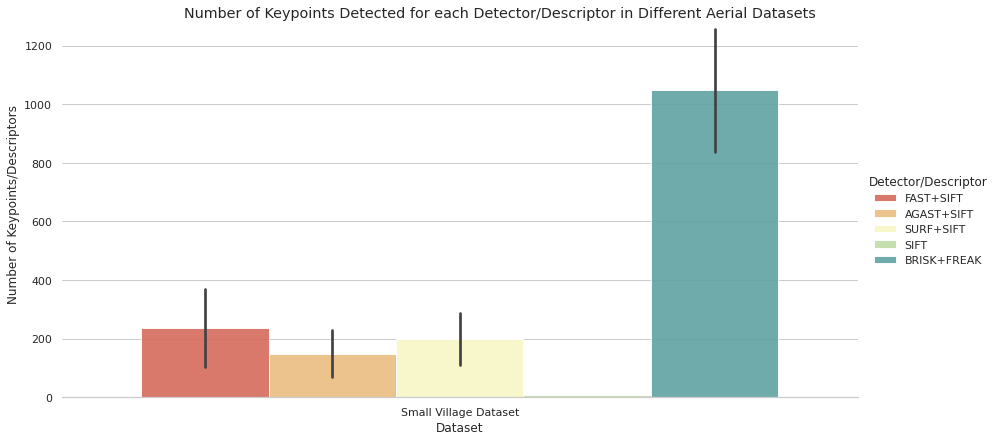

In [64]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_8_{Dataset}.png')

In [65]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [ ]:
#rint(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [68]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_fast + num_matches_agast + num_matches_freak + num_matches_sift + num_matches_surf, 'Detector/Descriptor': ['FAST+SIFT']*(len_files-1) + ['AGAST+SIFT']*(len_files-1) + ['SURF+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) }
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

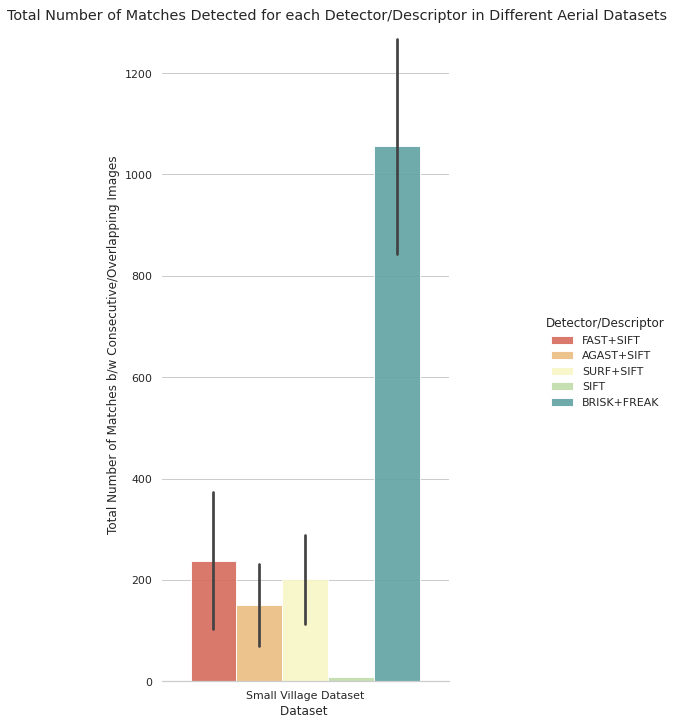

In [69]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_8_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [71]:
df_match_5['Number of Good Matches'] =  num_good_matches_fast + num_good_matches_agast + num_good_matches_freak + num_good_matches_sift + num_good_matches_surf
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

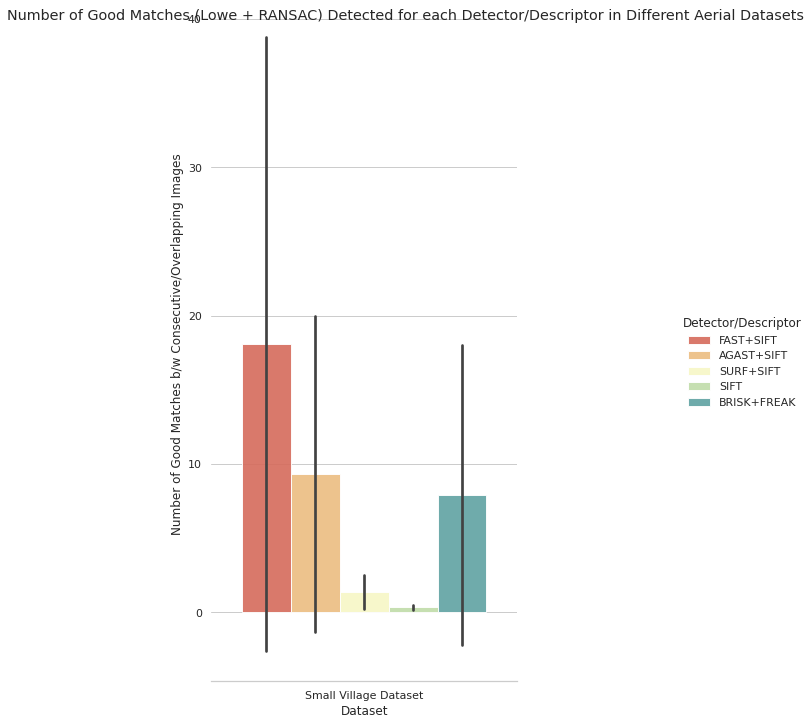

In [72]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_8.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [73]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

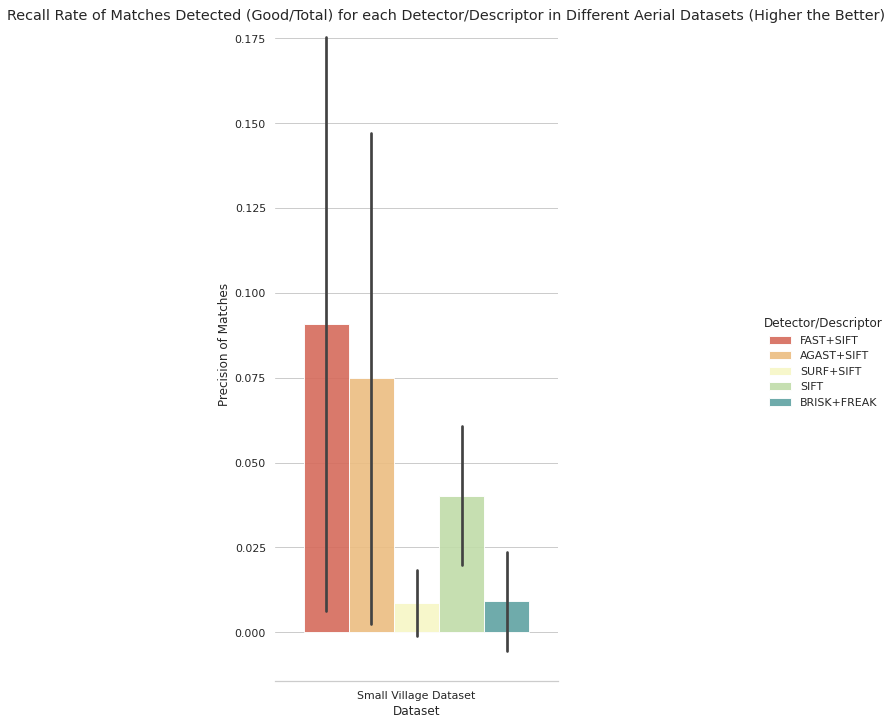

In [74]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_8.png')

1-Precision Rate for each Detector+Descriptor

In [75]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

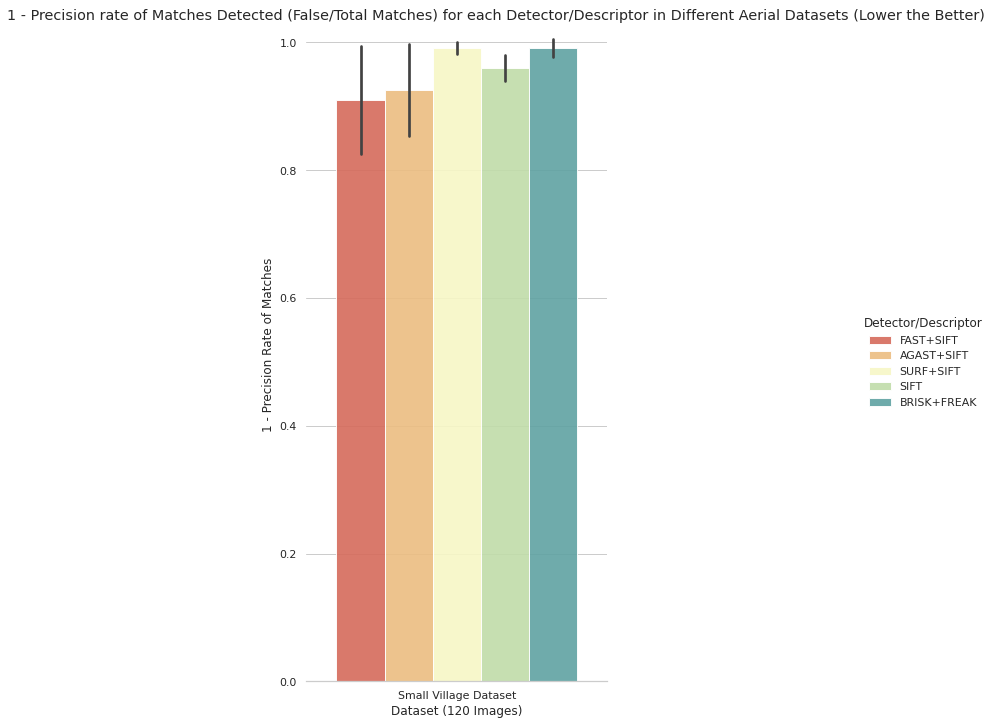

In [76]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5,kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_8.png')

F-Score for each Detector+Descriptor

In [77]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

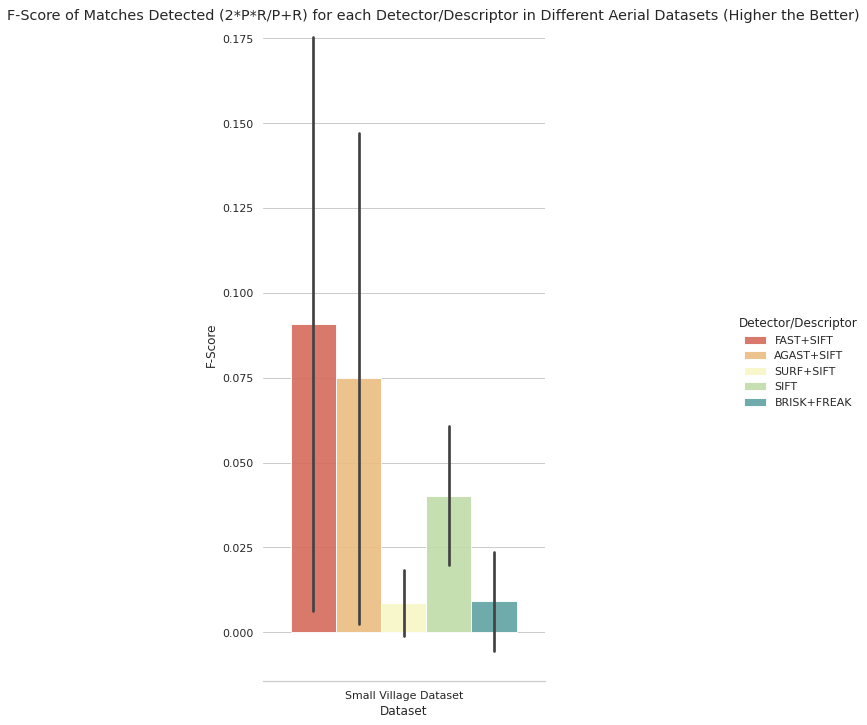

In [78]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_8.png')

In [79]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [80]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[0]] + [time_all[1]] + [time_all[2]] + [time_all[3]] + [time_all[4]], 'Detector/Descriptor': ['FAST+SIFT']*(1) +  ['AGAST+SIFT']*(1) + ['SURF+SIFT']*(1) + ['SIFT']*(1) + ['BRISK+FREAK']*(1)}
df_time_5 = pd.DataFrame(data=d)

In [81]:
print(df_time_5)

                 Dataset         Time Detector/Descriptor
0  Small Village Dataset   142.883806           FAST+SIFT
1  Small Village Dataset   235.124581          AGAST+SIFT
2  Small Village Dataset   330.170364           SURF+SIFT
3  Small Village Dataset   749.506500                SIFT
4  Small Village Dataset  1007.410338         BRISK+FREAK


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

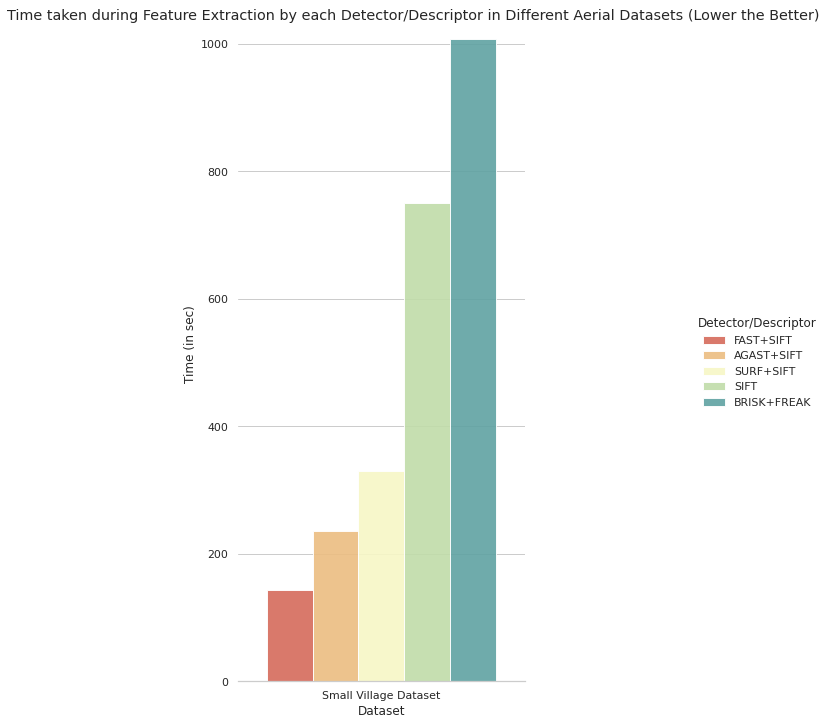

In [82]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_8.png')

In [83]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU